TFM: Uso de árboles de decisión y MLP en
la predicción de energía renovable


CLARA MARTÍN PÉREZ

DNI: 70925201D

# Librerías utilizadas

In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 15.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import logging
import importlib
import random
import itertools
import scipy.stats as stats
import statsmodels.api as sm

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import shap
import optuna


# XGBOOST

In [4]:
df_completo = pd.read_csv('df_final.csv', sep=",")
df_completo['time'] = pd.to_datetime(df_completo['time'])

In [5]:
df_completo['verano'] = df_completo['time'].dt.month.isin([5, 6, 7, 8]).astype(int)

In [6]:
df_test = df_completo[df_completo['time'].dt.year == 2022]
df_trainval = df_completo[df_completo['time'].dt.year != 2022]

In [ ]:
total_rows = len(df_completo)
print(f"Train: {len(df_trainval)} filas ({len(df_trainval)/total_rows:.2%})")
print(f"Test: {len(df_test)} filas ({len(df_test)/total_rows:.2%})")

Train: 51109 filas (85.38%)
Test: 8753 filas (14.62%)


In [ ]:
variables_predictoras = ['cos_hora',
            'sin_hora',
            'u100_punto_1',
            'u100_punto_2',
            'u100_punto_3',
            'u100_punto_4',
            'u100_punto_5',
            'u100_punto_6',
            'u100_punto_7',
            'u100_punto_8',
            'u100_punto_9',
            'u100_punto_10',
            'u100_punto_11',
            'u100_punto_12',
            'u100_punto_13',
            'u100_punto_14',
            'u100_punto_15',
            'u100_punto_16',
            'v100_punto_1',
            'v100_punto_2',
            'v100_punto_3',
            'v100_punto_4',
            'v100_punto_5',
            'v100_punto_6',
            'v100_punto_7',
            'v100_punto_8',
            'v100_punto_9',
            'v100_punto_10',
            'v100_punto_11',
            'v100_punto_12',
            'v100_punto_13',
            'v100_punto_14',
            'v100_punto_15',
            'v100_punto_16',
            'mean_wind_speed',
            'mean_wind_cubed',
            'wind_speed_punto_1',
            'wind_speed_punto_2',
            'wind_speed_punto_3',
            'wind_speed_punto_4',
            'wind_speed_punto_5',
            'wind_speed_punto_6',
            'wind_speed_punto_7',
            'wind_speed_punto_8',
            'wind_speed_punto_9',
            'wind_speed_punto_10',
            'wind_speed_punto_11',
            'wind_speed_punto_12',
            'wind_speed_punto_13',
            'wind_speed_punto_14',
            'wind_speed_punto_15',
            'wind_speed_punto_16',
            'wind_cubed_punto_1',
            'wind_cubed_punto_2',
            'wind_cubed_punto_3',
            'wind_cubed_punto_4',
            'wind_cubed_punto_5',
            'wind_cubed_punto_6',
            'wind_cubed_punto_7',
            'wind_cubed_punto_8',
            'wind_cubed_punto_9',
            'wind_cubed_punto_10',
            'wind_cubed_punto_11',
            'wind_cubed_punto_12',
            'wind_cubed_punto_13',
            'wind_cubed_punto_14',
            'wind_cubed_punto_15',
            'wind_cubed_punto_16',
            'wind_direction_sin_punto_1',
            'wind_direction_sin_punto_2',
            'wind_direction_sin_punto_3',
            'wind_direction_sin_punto_4',
            'wind_direction_sin_punto_5',
            'wind_direction_sin_punto_6',
            'wind_direction_sin_punto_7',
            'wind_direction_sin_punto_8',
            'wind_direction_sin_punto_9',
            'wind_direction_sin_punto_10',
            'wind_direction_sin_punto_11',
            'wind_direction_sin_punto_12',
            'wind_direction_sin_punto_13',
            'wind_direction_sin_punto_14',
            'wind_direction_sin_punto_15',
            'wind_direction_sin_punto_16',
            'wind_direction_cos_punto_1',
            'wind_direction_cos_punto_2',
            'wind_direction_cos_punto_3',
            'wind_direction_cos_punto_4',
            'wind_direction_cos_punto_5',
            'wind_direction_cos_punto_6',
            'wind_direction_cos_punto_7',
            'wind_direction_cos_punto_8',
            'wind_direction_cos_punto_9',
            'wind_direction_cos_punto_10',
            'wind_direction_cos_punto_11',
            'wind_direction_cos_punto_12',
            'wind_direction_cos_punto_13',
            'wind_direction_cos_punto_14',
            'wind_direction_cos_punto_15',
            'wind_direction_cos_punto_16'
            ]

objetivo = ['Tanto por 1']

In [ ]:
len(variables_predictoras)

100

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

División en los conjuntos train y val (lo hago por bloques para que el modelo no memorice patrones específicos en corto plazo)

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)


np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

# Función para expandir los índices de los bloques
def expand_blocks(block_indices):
    indices = []
    for b in block_indices:
        start = b * block_size
        indices.extend(range(start, start + block_size))
    return indices


train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

print(f"Train: {X_train.shape[0]} filas ({len(X_train)/total_rows:.2%})")
print(f"Val: {X_val.shape[0]} filas ({len(X_val)/total_rows:.2%})")

Train: 43500 filas (72.67%)
Val: 7600 filas (12.70%)


Tengo una partición del 72.67% filas en el conjunto de entrenamiento, 12.70% en el de validación y 14.62% en el de prueba (test).

##Selección de hiperparámetros

Aproximación inicial con GridSearch,  manteniendo todas las variables y fijando una semilla en el modelo base.

In [ ]:
modelo_base = xgb.XGBRegressor(
    objective='reg:absoluteerror',
    random_state=42,
    n_estimators=500
)

param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [4, 6],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 1],
    'reg_lambda': [1, 2,5],
    'min_child_weight': [1], #esto lo fijé (fui probando antes de hacer el gridsearch)
    'booster': ['gbtree'],
    'tree_method': ['hist']
}


grid_cv = GridSearchCV(
    estimator=modelo_base,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=2,
    n_jobs=-1,
    refit = True, #al terminar el GridSearch rehace el modelo final usando todos los datos de train con los mejores parámetros encontrados
    return_train_score = True, # para poder hacer grid_cv.cv_results_['mean_train_score'].
    error_score = np.nan, # si algún modelo peta durante el fit de un fold, ese score se pondrá como NaN y seguirá.
)

grid_cv.fit(X_trainval, y_trainval)

print("Mejores hiperparámetros encontrados:")
print(grid_cv.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores hiperparámetros encontrados:
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 5, 'subsample': 0.8, 'tree_method': 'hist'}


Resultados: {'booster': 'gbtree', 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 5, 'subsample': 0.8, 'tree_method': 'hist'}

Comprobación de que la aleatoriedad del modelo depende del subsample y del colsample_bytree:

In [ ]:
maes = []

for i in range(10):
    modelo = XGBRegressor(
        objective='reg:absoluteerror',
        n_estimators=100,
        subsample=1.0,
        colsample_bytree=1.0,
        # NO fijo random_state
    )
    modelo.fit(X_train, y_train)
    pred = modelo.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    maes.append(mae)

print("MAEs obtenidos:", maes)
print("¿Todos iguales?:", all([x == maes[0] for x in maes]))


MAEs obtenidos: [0.07549207632313966, 0.07549207632313966, 0.07549207632313966, 0.07549207632313966, 0.07549207632313966, 0.07549207632313966, 0.07549207632313966, 0.07549207632313966, 0.07549207632313966, 0.07549207632313966]
¿Todos iguales?: True


Defino y evalúo el modelo obtenido con los parámetros teniendo una primera aproximación y utilizando todas las variables predictoras:

In [ ]:
def calcular_metricas(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

def evaluar_estabilidad(X_train, y_train, X_val, y_val, X_test, y_test, mejores_params, n_iter=5):
    maes_test  = []
    maes_train = []
    maes_val = []
    rmses_test = []
    rmses_train = []
    rmses_val = []

    for i in range(n_iter):
        semilla = random.randint(0, 10000)
        modelo_xgb = xgb.XGBRegressor(
            objective='reg:absoluteerror',
            # tree_method='hist',
            random_state=semilla,
            early_stopping_rounds=60,
            **mejores_params,
            eval_metric = 'mae'
        )
        modelo_xgb.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=False
        )

        # Predicciones test y train
        y_pred_test = modelo_xgb.predict(X_test)
        y_pred_train = modelo_xgb.predict(X_train)
        y_pred_val = modelo_xgb.predict(X_val)

        # Métricas
        mse_test, rmse_test, mae_test = calcular_metricas(y_test, y_pred_test)
        mse_train, rmse_train, mae_train = calcular_metricas(y_train, y_pred_train)
        mse_val, rmse_val, mae_val = calcular_metricas(y_val, y_pred_val)

        maes_test.append(mae_test)
        maes_train.append(mae_train)
        maes_val.append(mae_val)

        rmses_test.append(rmse_test)
        rmses_train.append(rmse_train)
        rmses_val.append(rmse_val)

        # Mostrar resultados de esta iteración
        print(f"\nIteración {i+1}, random_state={semilla}")
        print("----- TRAIN -----")
        print(f"MSE:  {mse_train:.4f}")
        print(f"RMSE: {rmse_train:.4f}")
        print(f"MAE:  {mae_train:.4f}")

        print("----- VAL -----")
        print(f"MSE:  {mse_val:.4f}")
        print(f"RMSE: {rmse_val:.4f}")
        print(f"MAE:  {mae_val:.4f}")


        print("----- TEST -----")
        print(f"MSE:  {mse_test:.4f}")
        print(f"RMSE: {rmse_test:.4f}")
        print(f"MAE:  {mae_test:.4f}")

    # Estadísticos de test
    media_mae_test = np.mean(maes_test)
    std_mae_test   = np.std(maes_test)

    print(f"\nMAE TEST promedio: {media_mae_test:.5f} ± {std_mae_test:.5f}")

    return modelo_xgb

In [ ]:
mejores_params ={'booster': 'gbtree', 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1,
 'max_depth': 4, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 5,
                 'subsample': 0.8, 'tree_method': 'hist','n_estimators': 10000}

In [ ]:
modelo_xgb = evaluar_estabilidad(X_train, y_train, X_val, y_val, X_test, y_test, mejores_params, n_iter=5)


Iteración 1, random_state=9934
----- TRAIN -----
MSE:  0.0113
RMSE: 0.1063
MAE:  0.0699
----- VAL -----
MSE:  0.0113
RMSE: 0.1065
MAE:  0.0707
----- TEST -----
MSE:  0.0125
RMSE: 0.1118
MAE:  0.0744

Iteración 2, random_state=2160
----- TRAIN -----
MSE:  0.0110
RMSE: 0.1050
MAE:  0.0688
----- VAL -----
MSE:  0.0114
RMSE: 0.1068
MAE:  0.0709
----- TEST -----
MSE:  0.0125
RMSE: 0.1118
MAE:  0.0744

Iteración 3, random_state=2848
----- TRAIN -----
MSE:  0.0112
RMSE: 0.1057
MAE:  0.0695
----- VAL -----
MSE:  0.0114
RMSE: 0.1069
MAE:  0.0710
----- TEST -----
MSE:  0.0125
RMSE: 0.1116
MAE:  0.0744

Iteración 4, random_state=178
----- TRAIN -----
MSE:  0.0114
RMSE: 0.1070
MAE:  0.0706
----- VAL -----
MSE:  0.0114
RMSE: 0.1070
MAE:  0.0709
----- TEST -----
MSE:  0.0126
RMSE: 0.1123
MAE:  0.0747

Iteración 5, random_state=6911
----- TRAIN -----
MSE:  0.0108
RMSE: 0.1038
MAE:  0.0678
----- VAL -----
MSE:  0.0113
RMSE: 0.1062
MAE:  0.0707
----- TEST -----
MSE:  0.0124
RMSE: 0.1116
MAE:  0.0743



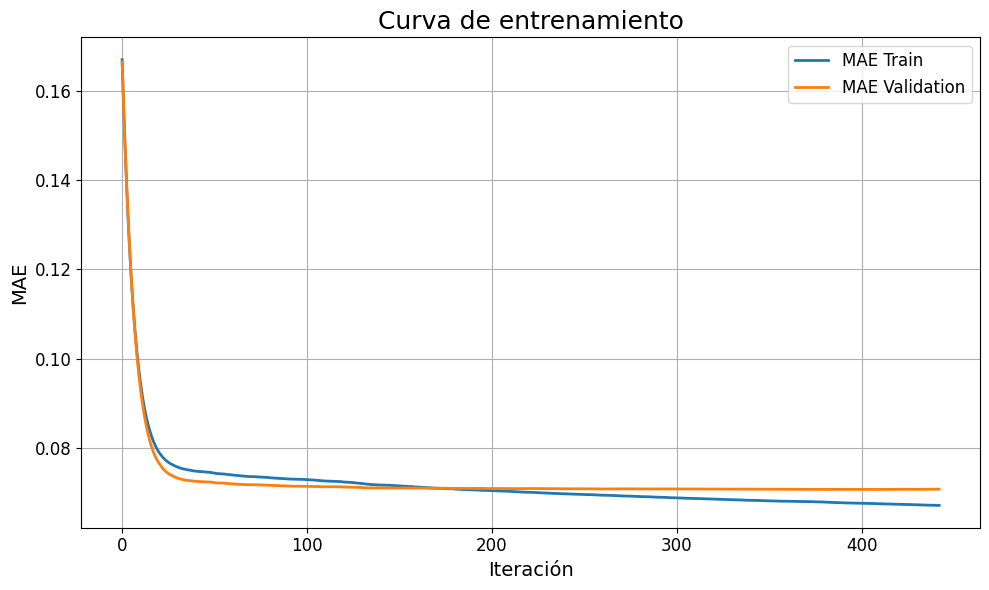

In [ ]:
evals_result = modelo_xgb.evals_result()

train_error = evals_result['validation_0']['mae']
val_error   = evals_result['validation_1']['mae']

plt.figure(figsize=(10, 6))

plt.plot(train_error, label='MAE Train', linewidth=2)
plt.plot(val_error, label='MAE Validation', linewidth=2)

plt.xlabel('Iteración', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.title('Curva de entrenamiento', fontsize=18)

plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
pd.set_option('display.max_rows', None) # para que se muestren todas las filas

# Cálculo de la importancia de las variables
importancias = modelo_xgb.feature_importances_

df_importancia = pd.DataFrame({
    'feature': X_train.columns,
    'importancia': importancias
}).sort_values(by='importancia', ascending=False)

df_importancia

feature  importancia
65          wind_cubed_punto_14     0.300847
49          wind_speed_punto_14     0.213650
35              mean_wind_cubed     0.081052
50          wind_speed_punto_15     0.053808
46          wind_speed_punto_11     0.036583
34              mean_wind_speed     0.036138
48          wind_speed_punto_13     0.016570
64          wind_cubed_punto_13     0.013776
54           wind_cubed_punto_3     0.009200
47          wind_speed_punto_12     0.007686
38           wind_speed_punto_3     0.006862
39           wind_speed_punto_4     0.005268
58           wind_cubed_punto_7     0.005182
33                v100_punto_16     0.004287
53           wind_cubed_punto_2     0.004019
51          wind_speed_punto_16     0.003985
16                u100_punto_15     0.003965
0                      cos_hora     0.003803
42           wind_speed_punto_7     0.003708
37           wind_speed_punto_2     0.003520
17                u100_punto_16     0.003516
67          wind_cubed_punto_16     0.003357
1                      sin_hora     0.003317
25                 v100_punto_8     0.003235
83  wind_direction_sin_punto_16     0.003118
80  wind_direction_sin_punto_13     0.003064
20                 v100_punto_3     0.002985
21                 v100_punto_4     0.002940
63          wind_cubed_punto_12     0.002907
92   wind_direction_cos_punto_9     0.002902
82  wind_direction_sin_punto_15     0.002878
24                 v100_punto_7     0.002864
61          wind_cubed_punto_10     0.002837
29                v100_punto_12     0.002800
32                v100_punto_15     0.002780
13                u100_punto_12     0.002768
15                u100_punto_14     0.002675
14                u100_punto_13     0.002665
41           wind_speed_punto_6     0.002598
88   wind_direction_cos_punto_5     0.002593
75   wind_direction_sin_punto_8     0.002577
57           wind_cubed_punto_6     0.002557
91   wind_direction_cos_punto_8     0.002509
99  wind_direction_cos_punto_16     0.002505
2                  u100_punto_1     0.002503
27                v100_punto_10     0.002500
12                u100_punto_11     0.002497
31                v100_punto_14     0.002495
4                  u100_punto_3     0.002477
3                  u100_punto_2     0.002450
5                  u100_punto_4     0.002444
56           wind_cubed_punto_5     0.002436
43           wind_speed_punto_8     0.002434
70   wind_direction_sin_punto_3     0.002337
77  wind_direction_sin_punto_10     0.002316
81  wind_direction_sin_punto_14     0.002298
89   wind_direction_cos_punto_6     0.002298
26                 v100_punto_9     0.002285
10                 u100_punto_9     0.002274
87   wind_direction_cos_punto_4     0.002226
30                v100_punto_13     0.002222
52           wind_cubed_punto_1     0.002209
40           wind_speed_punto_5     0.002165
28                v100_punto_11     0.002160
71   wind_direction_sin_punto_4     0.002147
85   wind_direction_cos_punto_2     0.002145
94  wind_direction_cos_punto_11     0.002143
11                u100_punto_10     0.002119
66          wind_cubed_punto_15     0.002103
79  wind_direction_sin_punto_12     0.002080
55           wind_cubed_punto_4     0.002073
6                  u100_punto_5     0.002072
7                  u100_punto_6     0.002069
18                 v100_punto_1     0.002065
96  wind_direction_cos_punto_13     0.002058
59           wind_cubed_punto_8     0.002049
69   wind_direction_sin_punto_2     0.002046
45          wind_speed_punto_10     0.002038
97  wind_direction_cos_punto_14     0.002038
9                  u100_punto_8     0.002034
19                 v100_punto_2     0.002033
84   wind_direction_cos_punto_1     0.001971
72   wind_direction_sin_punto_5     0.001964
73   wind_direction_sin_punto_6     0.001941
22                 v100_punto_5     0.001935
36           wind_speed_punto_1     0.001931
23                 v100_punto_6     0.001927
78  wind_direction_sin_punto_11     0.001912
95  wind_direction_

In [ ]:
pd.reset_option('display.max_rows')

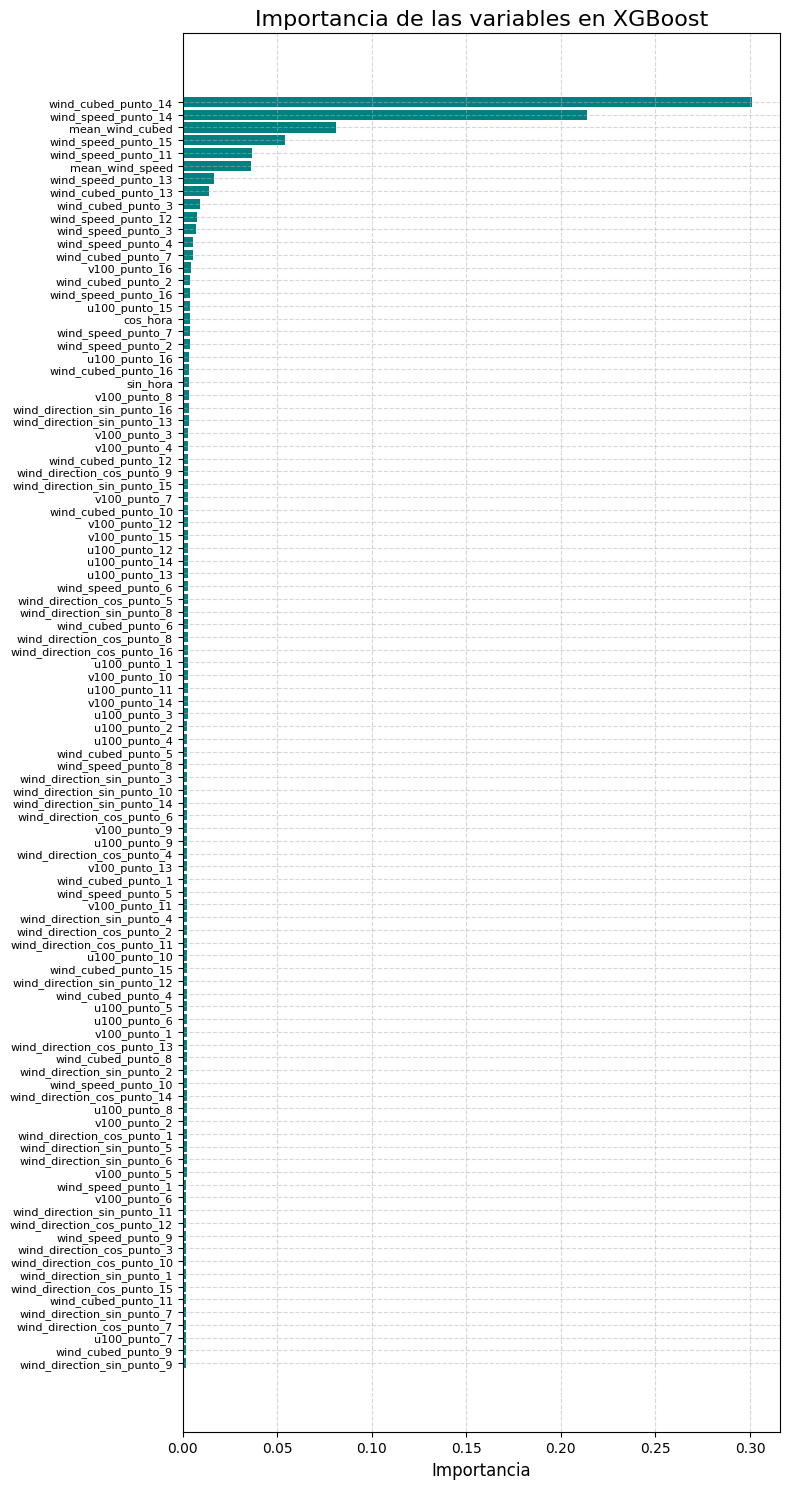

In [ ]:
plt.figure(figsize=(8, 15))
plt.barh(df_importancia['feature'], df_importancia['importancia'], color='teal')
plt.xlabel('Importancia', fontsize=12)
plt.title('Importancia de las variables en XGBoost', fontsize=16)
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.5)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


Las medias son las variables más importantes.

<ipython-input-18-22a5beb37ae4>:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


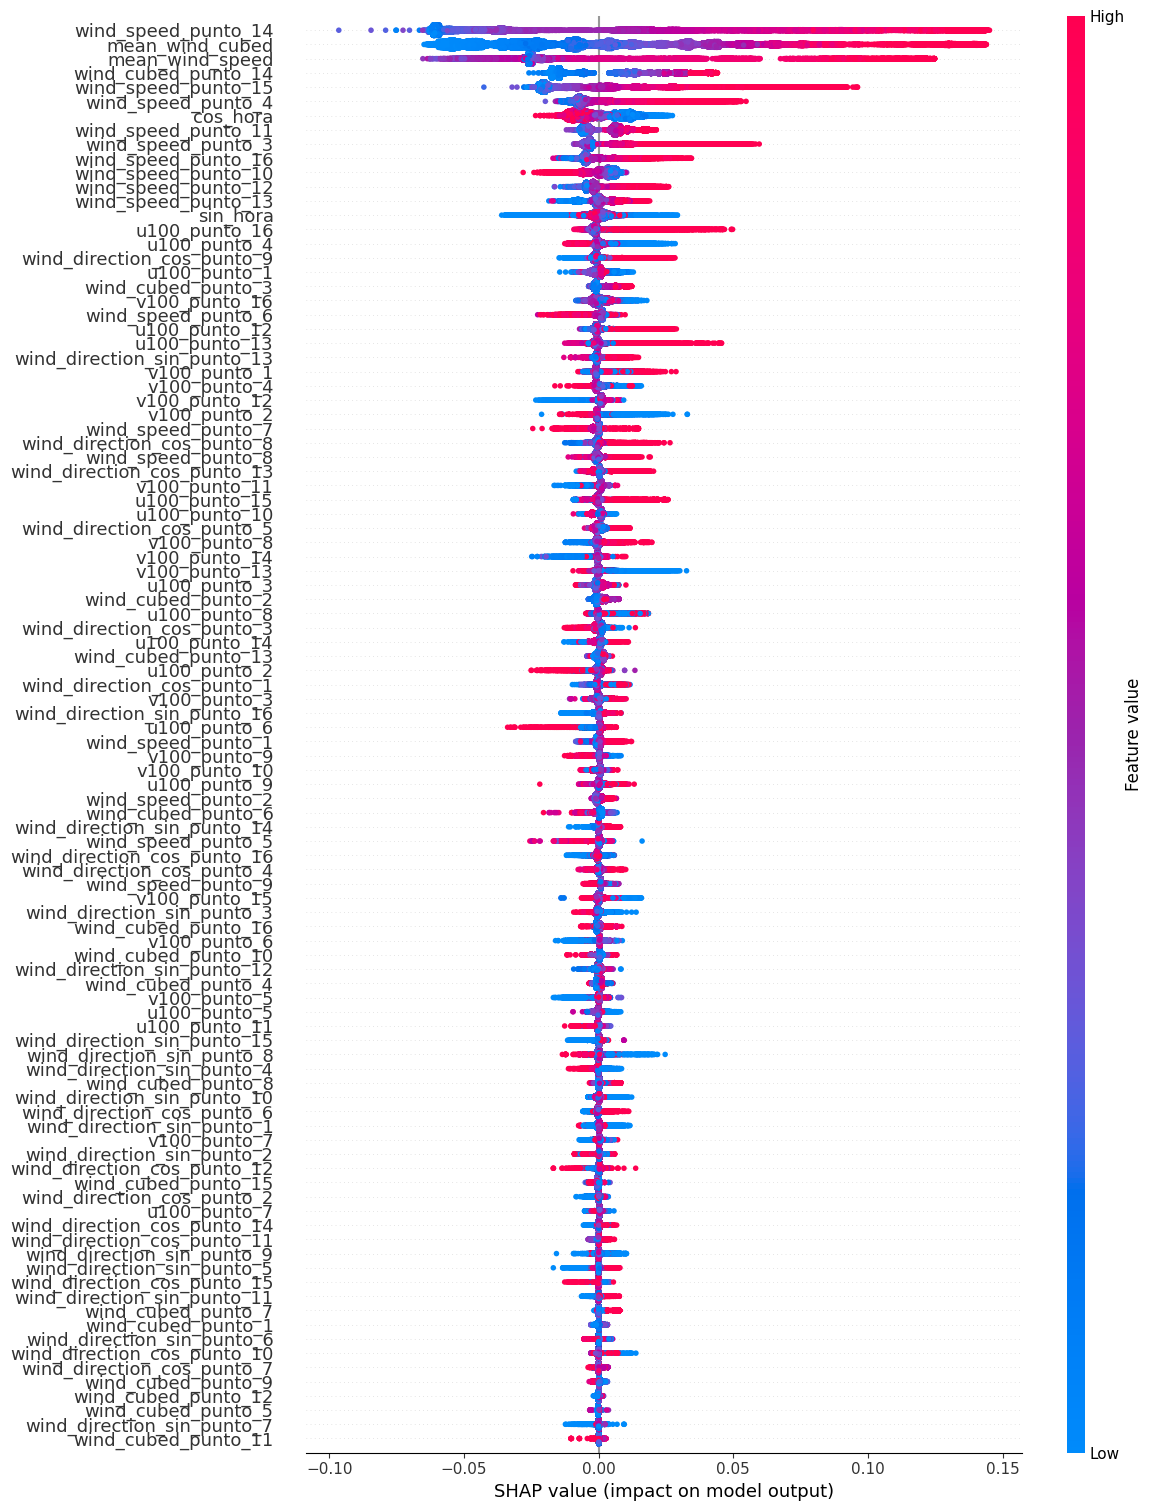

In [ ]:
explainer = shap.TreeExplainer(modelo_xgb)

shap_values = explainer.shap_values(X_train)

plt.rcParams.update({'font.size': 3})

shap.summary_plot(
    shap_values,
    X_train,
    max_display=100,  # muestro las 100 variables
    plot_size=(12, 15)
)


##Selección de variables predictoras

Fui probando distintas combinaciones (comentando distintas variables, dividiendo de nuevo los conjuntos y evaluando el modelo resultante)

In [ ]:
variables_predictoras = [
            'cos_hora',
            'sin_hora',
            'verano',
            'u100_punto_1',
            'u100_punto_2',
            'u100_punto_3',
            'u100_punto_4',
            'u100_punto_5',
            'u100_punto_6',
            'u100_punto_7',
            'u100_punto_8',
            'u100_punto_9',
            'u100_punto_10',
            'u100_punto_11',
            'u100_punto_12',
            'u100_punto_13',
            'u100_punto_14',
            'u100_punto_15',
            'u100_punto_16',
            'v100_punto_1',
            'v100_punto_2',
            'v100_punto_3',
            'v100_punto_4',
            'v100_punto_5',
            'v100_punto_6',
            'v100_punto_7',
            'v100_punto_8',
            'v100_punto_9',
            'v100_punto_10',
            'v100_punto_11',
            'v100_punto_12',
            'v100_punto_13',
            'v100_punto_14',
            'v100_punto_15',
            'v100_punto_16',
            'mean_wind_speed',
            'mean_wind_cubed'
            # 'wind_speed_punto_1',
            # 'wind_speed_punto_2',
            # 'wind_speed_punto_3',
            # 'wind_speed_punto_4',
            # 'wind_speed_punto_5',
            # 'wind_speed_punto_6',
            # 'wind_speed_punto_7',
            # 'wind_speed_punto_8',
            # 'wind_speed_punto_9',
            # 'wind_speed_punto_10',
            # 'wind_speed_punto_11',
            # 'wind_speed_punto_12',
            # 'wind_speed_punto_13',
            # 'wind_speed_punto_14',
            # 'wind_speed_punto_15',
            # 'wind_speed_punto_16',
            # 'wind_cubed_punto_1',
            # 'wind_cubed_punto_2',
            # 'wind_cubed_punto_3',
            # 'wind_cubed_punto_4',
            # 'wind_cubed_punto_5',
            # 'wind_cubed_punto_6',
            # 'wind_cubed_punto_7',
            # 'wind_cubed_punto_8',
            # 'wind_cubed_punto_9',
            # 'wind_cubed_punto_10',
            # 'wind_cubed_punto_11',
            # 'wind_cubed_punto_12',
            # 'wind_cubed_punto_13',
            # 'wind_cubed_punto_14',
            # 'wind_cubed_punto_15',
            # 'wind_cubed_punto_16',
            # 'wind_direction_sin_punto_1',
            # 'wind_direction_sin_punto_2',
            # 'wind_direction_sin_punto_3',
            # 'wind_direction_sin_punto_4',
            # 'wind_direction_sin_punto_5',
            # 'wind_direction_sin_punto_6',
            # 'wind_direction_sin_punto_7',
            # 'wind_direction_sin_punto_8',
            # 'wind_direction_sin_punto_9',
            # 'wind_direction_sin_punto_10',
            # 'wind_direction_sin_punto_11',
            # 'wind_direction_sin_punto_12',
            # 'wind_direction_sin_punto_13',
            # 'wind_direction_sin_punto_14',
            # 'wind_direction_sin_punto_15',
            # 'wind_direction_sin_punto_16',
            # 'wind_direction_cos_punto_1',
            # 'wind_direction_cos_punto_2',
            # 'wind_direction_cos_punto_3',
            # 'wind_direction_cos_punto_4',
            # 'wind_direction_cos_punto_5',
            # 'wind_direction_cos_punto_6',
            # 'wind_direction_cos_punto_7',
            # 'wind_direction_cos_punto_8',
            # 'wind_direction_cos_punto_9',
            # 'wind_direction_cos_punto_10',
            # 'wind_direction_cos_punto_11',
            # 'wind_direction_cos_punto_12',
            # 'wind_direction_cos_punto_13',
            # 'wind_direction_cos_punto_14',
            # 'wind_direction_cos_punto_15',
            # 'wind_direction_cos_punto_16'
            ]

objetivo = ['Tanto por 1']

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43500 filas
Val: 7600 filas


In [7]:
def calcular_metricas(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

def evaluar_estabilidad(X_train, y_train, X_val, y_val, X_test, y_test, mejores_params, n_iter=5):
    maes_test  = []
    maes_train = []
    maes_val = []
    rmses_test = []
    rmses_train = []
    rmses_val = []

    for i in range(n_iter):
        semilla = random.randint(0, 10000)
        modelo_xgb = xgb.XGBRegressor(
            objective='reg:absoluteerror',
            random_state=semilla,
            early_stopping_rounds=10,
            **mejores_params
        )
        modelo_xgb.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        y_pred_test = modelo_xgb.predict(X_test)
        y_pred_train = modelo_xgb.predict(X_train)
        y_pred_val = modelo_xgb.predict(X_val)

        mse_test, rmse_test, mae_test = calcular_metricas(y_test, y_pred_test)
        mse_train, rmse_train, mae_train = calcular_metricas(y_train, y_pred_train)
        mse_val, rmse_val, mae_val = calcular_metricas(y_val, y_pred_val)

        maes_test.append(mae_test)
        maes_train.append(mae_train)
        maes_val.append(mae_val)

        rmses_test.append(rmse_test)
        rmses_train.append(rmse_train)
        rmses_val.append(rmse_val)

        print(f"\nIteración {i+1}, random_state={semilla}")
        print("----- TRAIN -----")
        print(f"MSE:  {mse_train:.4f}")
        print(f"RMSE: {rmse_train:.4f}")
        print(f"MAE:  {mae_train:.4f}")

        print("----- VAL -----")
        print(f"MSE:  {mse_val:.4f}")
        print(f"RMSE: {rmse_val:.4f}")
        print(f"MAE:  {mae_val:.4f}")


        print("----- TEST -----")
        print(f"MSE:  {mse_test:.4f}")
        print(f"RMSE: {rmse_test:.4f}")
        print(f"MAE:  {mae_test:.4f}")

    media_mae_test = np.mean(maes_test)
    std_mae_test   = np.std(maes_test)

    print(f"\nMAE TEST promedio: {media_mae_test:.5f} ± {std_mae_test:.5f}")
    return media_mae_test

In [ ]:
mejores_params ={'booster': 'gbtree', 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1,
 'max_depth': 4, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 5,
                 'subsample': 0.8, 'tree_method': 'hist','n_estimators': 10000}

In [ ]:
evaluar_estabilidad(X_train, y_train, X_val, y_val, X_test, y_test, mejores_params, n_iter=5)


Iteración 1, random_state=6860
----- TRAIN -----
MSE:  0.0118
RMSE: 0.1084
MAE:  0.0720
----- VAL -----
MSE:  0.0115
RMSE: 0.1075
MAE:  0.0713
----- TEST -----
MSE:  0.0126
RMSE: 0.1121
MAE:  0.0748

Iteración 2, random_state=6182
----- TRAIN -----
MSE:  0.0114
RMSE: 0.1069
MAE:  0.0707
----- VAL -----
MSE:  0.0115
RMSE: 0.1074
MAE:  0.0711
----- TEST -----
MSE:  0.0124
RMSE: 0.1114
MAE:  0.0742

Iteración 3, random_state=6288
----- TRAIN -----
MSE:  0.0112
RMSE: 0.1059
MAE:  0.0698
----- VAL -----
MSE:  0.0115
RMSE: 0.1070
MAE:  0.0710
----- TEST -----
MSE:  0.0123
RMSE: 0.1111
MAE:  0.0740

Iteración 4, random_state=6558
----- TRAIN -----
MSE:  0.0116
RMSE: 0.1075
MAE:  0.0713
----- VAL -----
MSE:  0.0116
RMSE: 0.1075
MAE:  0.0711
----- TEST -----
MSE:  0.0125
RMSE: 0.1119
MAE:  0.0746

Iteración 5, random_state=515
----- TRAIN -----
MSE:  0.0118
RMSE: 0.1087
MAE:  0.0723
----- VAL -----
MSE:  0.0116
RMSE: 0.1078
MAE:  0.0713
----- TEST -----
MSE:  0.0126
RMSE: 0.1124
MAE:  0.0749



In [ ]:
len(variables_predictoras)

101

COMBINACIONES FINALES: (todas con verano y hora, porque tras hacer numerosas pruebas se comprobó que aportaban información)
1.	Componentes del viento (35): 0.07460 ± 0.00008
2.	Componentes del viento y media de la velocidad del viento y de la velocidad cúbica (37): 0.07370 ± 0.00016
3.	Componentes del viento, velocidad del viento y medias de la velocidad del viento y de la velocidad cúbica (52):   0.07462 ± 0.00017
4.	Componentes del viento, velocidad al cubo del viento y medias de la velocidad del viento y de la velocidad cúbica: 0.07415 ± 0.00031
5.	Componentes del viento, velocidad al cubo y velocidad (67): 0.07450 ± 0.00013
6.	Componentes del viento, velocidad al cubo, velocidad y medias de estas 2 últimas (69): 0.07440 ± 0.00040
7.	Componentes del viento, velocidad y dirección del viento (en forma de sin y cos) (83): 0.07497 ± 0.00040
8.	Componentes del viento, velocidad, dirección del viento y medias (85): 0.07457 ± 0.00037
9.	Todas las variables (101): 0.07453 ± 0.00035


## Previsiones meteorológicas de otras horas y recorte del mapa

Se prueba a añadir como variables predictoras las previsiones meteorológicas de otras horas y también a utilizar la mitad del mapa.

In [8]:
lags = range(-3, 4)
variables = [col for col in df_completo.columns if col.startswith(('u100', 'v100', 'mean_wind_speed', 'mean_wind_cubed'))]

# Genero retardos de las variables (relacionadas con las previsiones meteorológicas)
for var in variables:
    for lag in lags:
        nombre_nueva_columna = f"{var}_lag{lag}"
        df_completo[nombre_nueva_columna] = df_completo[var].shift(lag)

# Elimino las filas con NaN provocadas por los retardos
df_completo = df_completo.dropna().reset_index(drop=True)

<ipython-input-8-3345897645>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_completo[nombre_nueva_columna] = df_completo[var].shift(lag)
<ipython-input-8-3345897645>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_completo[nombre_nueva_columna] = df_completo[var].shift(lag)
<ipython-input-8-3345897645>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

In [9]:
# Los defino de nuevo para que también incluyan las nuevas variables creadas.
df_test = df_completo[df_completo['time'].dt.year == 2022]
df_trainval = df_completo[df_completo['time'].dt.year != 2022]

A continuación pruebo 6 combinaciones:
- Añadir las previsiones de la hora anterior y de la siguiente
- Añadir las previsiones de las 2 horas anteriores y siguientes
- Añadir las previsiones de las 3 horas anteriores y siguientes
También pruebo las 3 combinaciones anteriores pero considerando solo medio mapa.

#### Anterior y siguiente

In [ ]:
# Selecciono las variables predictoras para la primera combinación:
variables_originales = [col for col in df_completo.columns if col.startswith(('u100', 'v100', 'mean_wind_speed', 'mean_wind_cubed'))
                        and '_lag' not in col] #variables predictoras originales


lags = [-1, 0, 1]
variables_predictoras = [f"{var}_lag{lag}" for var in variables_originales for lag in lags]
variables_predictoras = variables_predictoras + ['sin_hora', 'cos_hora', 'verano']

print(variables_predictoras)

['u100_punto_1_lag-1', 'u100_punto_1_lag0', 'u100_punto_1_lag1', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_2_lag-1', 'u100_punto_2_lag0', 'u100_punto_2_lag1', 'u100_punto_3_lag-1', 'u100_punto_3_lag0', 'u100_punto_3_lag1', 'u100_punto_4_lag-1', 'u100_punto_4_lag0', 'u100_punto_4_lag1', 'u100_punto_5_lag-1', 'u100_punto_5_lag0', 'u100_punto_5_lag1', 'u100_punto_6_lag-1', 'u100_punto_6_lag0', 'u100_punto_6_lag1', 'u100_punto_7_lag-1', 'u100_punto_7_lag0', 'u100_punto_7_lag1', 'u100_punto_8_lag-1', 'u100_punto_8_lag0', 'u100_punto_8_lag1', 'u100_punto_9_lag-

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]
train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

Train: 43500 filas
Val: 7600 filas


In [ ]:
mejores_params ={'booster': 'gbtree', 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1,
 'max_depth': 4, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 5,
                 'subsample': 0.8, 'tree_method': 'hist','n_estimators': 10000}

In [ ]:
len(variables_predictoras)

105

In [ ]:
evaluar_estabilidad(
    X_train, y_train, X_val, y_val, X_test, y_test,
    mejores_params, n_iter=5
)


Iteración 1, random_state=3056
----- TRAIN -----
MSE:  0.0108
RMSE: 0.1038
MAE:  0.0685
----- VAL -----
MSE:  0.0108
RMSE: 0.1039
MAE:  0.0685
----- TEST -----
MSE:  0.0110
RMSE: 0.1047
MAE:  0.0700

Iteración 2, random_state=3642
----- TRAIN -----
MSE:  0.0102
RMSE: 0.1012
MAE:  0.0663
----- VAL -----
MSE:  0.0107
RMSE: 0.1033
MAE:  0.0681
----- TEST -----
MSE:  0.0109
RMSE: 0.1046
MAE:  0.0697

Iteración 3, random_state=4854
----- TRAIN -----
MSE:  0.0102
RMSE: 0.1010
MAE:  0.0662
----- VAL -----
MSE:  0.0107
RMSE: 0.1034
MAE:  0.0683
----- TEST -----
MSE:  0.0109
RMSE: 0.1045
MAE:  0.0697

Iteración 4, random_state=5397
----- TRAIN -----
MSE:  0.0105
RMSE: 0.1025
MAE:  0.0674
----- VAL -----
MSE:  0.0108
RMSE: 0.1038
MAE:  0.0684
----- TEST -----
MSE:  0.0109
RMSE: 0.1045
MAE:  0.0698

Iteración 5, random_state=367
----- TRAIN -----
MSE:  0.0105
RMSE: 0.1023
MAE:  0.0673
----- VAL -----
MSE:  0.0107
RMSE: 0.1034
MAE:  0.0682
----- TEST -----
MSE:  0.0110
RMSE: 0.1048
MAE:  0.0699



#### 2 anteriores y siguientes

In [ ]:
variables_originales = [col for col in df_completo.columns if col.startswith(('u100', 'v100', 'mean_wind_speed', 'mean_wind_cubed'))
                        and '_lag' not in col]

lags = [-2, -1, 0, 1, 2]
variables_predictoras = [f"{var}_lag{lag}" for var in variables_originales for lag in lags]
variables_predictoras = variables_predictoras + ['sin_hora', 'cos_hora', 'verano']
print(variables_predictoras)

['u100_punto_1_lag-2', 'u100_punto_1_lag-1', 'u100_punto_1_lag0', 'u100_punto_1_lag1', 'u100_punto_1_lag2', 'u100_punto_10_lag-2', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_10_lag2', 'u100_punto_11_lag-2', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_11_lag2', 'u100_punto_12_lag-2', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_12_lag2', 'u100_punto_13_lag-2', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_13_lag2', 'u100_punto_14_lag-2', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_14_lag2', 'u100_punto_15_lag-2', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_15_lag2', 'u100_punto_16_lag-2', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_16_lag2', 'u100_punto_2_lag-2', 'u100_punto_2_lag-1', 'u100_punto_2_lag0', 'u100_punto_2_lag1', 'u100_punto_2_lag2', '

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]
train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

Train: 43500 filas
Val: 7600 filas


In [ ]:
len(variables_predictoras)

173

In [ ]:
evaluar_estabilidad(
    X_train, y_train, X_val, y_val, X_test, y_test,
    mejores_params, n_iter=5
)


Iteración 1, random_state=4126
----- TRAIN -----
MSE:  0.0103
RMSE: 0.1015
MAE:  0.0667
----- VAL -----
MSE:  0.0106
RMSE: 0.1027
MAE:  0.0676
----- TEST -----
MSE:  0.0107
RMSE: 0.1033
MAE:  0.0688

Iteración 2, random_state=5254
----- TRAIN -----
MSE:  0.0102
RMSE: 0.1010
MAE:  0.0662
----- VAL -----
MSE:  0.0105
RMSE: 0.1024
MAE:  0.0674
----- TEST -----
MSE:  0.0107
RMSE: 0.1034
MAE:  0.0688

Iteración 3, random_state=2884
----- TRAIN -----
MSE:  0.0104
RMSE: 0.1019
MAE:  0.0669
----- VAL -----
MSE:  0.0105
RMSE: 0.1027
MAE:  0.0676
----- TEST -----
MSE:  0.0107
RMSE: 0.1036
MAE:  0.0691

Iteración 4, random_state=2110
----- TRAIN -----
MSE:  0.0106
RMSE: 0.1028
MAE:  0.0678
----- VAL -----
MSE:  0.0107
RMSE: 0.1033
MAE:  0.0679
----- TEST -----
MSE:  0.0108
RMSE: 0.1039
MAE:  0.0693

Iteración 5, random_state=9920
----- TRAIN -----
MSE:  0.0102
RMSE: 0.1008
MAE:  0.0661
----- VAL -----
MSE:  0.0106
RMSE: 0.1028
MAE:  0.0676
----- TEST -----
MSE:  0.0107
RMSE: 0.1033
MAE:  0.0689


#### 3 anteriores y siguientes

In [ ]:
variables_originales = [col for col in df_completo.columns if col.startswith(('u100', 'v100', 'mean_wind_speed', 'mean_wind_cubed'))
                        and '_lag' not in col]

lags = [-3, -2, -1, 0, 1, 2, 3]
variables_predictoras = [f"{var}_lag{lag}" for var in variables_originales for lag in lags]
variables_predictoras = variables_predictoras + ['sin_hora', 'cos_hora', 'verano']
print(variables_predictoras)

['u100_punto_1_lag-3', 'u100_punto_1_lag-2', 'u100_punto_1_lag-1', 'u100_punto_1_lag0', 'u100_punto_1_lag1', 'u100_punto_1_lag2', 'u100_punto_1_lag3', 'u100_punto_10_lag-3', 'u100_punto_10_lag-2', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_10_lag2', 'u100_punto_10_lag3', 'u100_punto_11_lag-3', 'u100_punto_11_lag-2', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_11_lag2', 'u100_punto_11_lag3', 'u100_punto_12_lag-3', 'u100_punto_12_lag-2', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_12_lag2', 'u100_punto_12_lag3', 'u100_punto_13_lag-3', 'u100_punto_13_lag-2', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_13_lag2', 'u100_punto_13_lag3', 'u100_punto_14_lag-3', 'u100_punto_14_lag-2', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_14_lag2', 'u100_punto_14_lag3', 'u100_punto_15_lag-3', 'u100_punto_15_lag-2', 'u100_punto_15_lag

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]
train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]


Train: 43500 filas
Val: 7600 filas


In [ ]:
len(variables_predictoras)

241

In [ ]:
evaluar_estabilidad(
    X_train, y_train, X_val, y_val, X_test, y_test,
    mejores_params, n_iter=5
)


Iteración 1, random_state=6438
----- TRAIN -----
MSE:  0.0097
RMSE: 0.0985
MAE:  0.0642
----- VAL -----
MSE:  0.0104
RMSE: 0.1020
MAE:  0.0671
----- TEST -----
MSE:  0.0106
RMSE: 0.1028
MAE:  0.0684

Iteración 2, random_state=1540
----- TRAIN -----
MSE:  0.0100
RMSE: 0.1001
MAE:  0.0654
----- VAL -----
MSE:  0.0104
RMSE: 0.1021
MAE:  0.0670
----- TEST -----
MSE:  0.0106
RMSE: 0.1029
MAE:  0.0686

Iteración 3, random_state=9839
----- TRAIN -----
MSE:  0.0100
RMSE: 0.0999
MAE:  0.0653
----- VAL -----
MSE:  0.0105
RMSE: 0.1026
MAE:  0.0672
----- TEST -----
MSE:  0.0105
RMSE: 0.1026
MAE:  0.0684

Iteración 4, random_state=2953
----- TRAIN -----
MSE:  0.0097
RMSE: 0.0984
MAE:  0.0641
----- VAL -----
MSE:  0.0103
RMSE: 0.1016
MAE:  0.0670
----- TEST -----
MSE:  0.0105
RMSE: 0.1026
MAE:  0.0683

Iteración 5, random_state=3408
----- TRAIN -----
MSE:  0.0100
RMSE: 0.0998
MAE:  0.0653
----- VAL -----
MSE:  0.0104
RMSE: 0.1022
MAE:  0.0672
----- TEST -----
MSE:  0.0106
RMSE: 0.1027
MAE:  0.0685


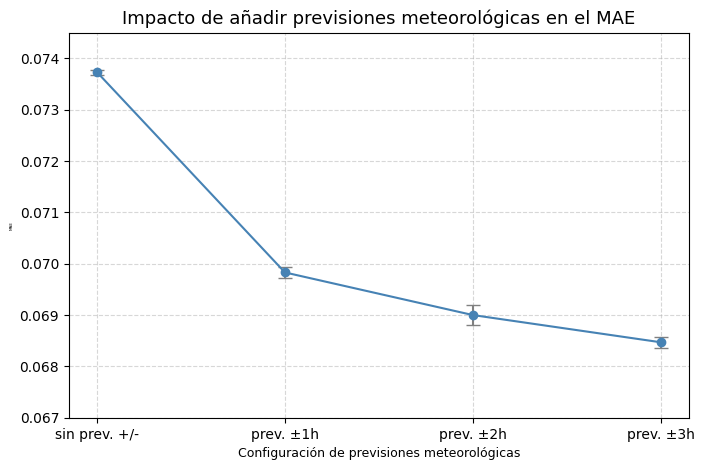

In [ ]:
import matplotlib.pyplot as plt

configuraciones = ['sin prev. +/-', 'prev. ±1h', 'prev. ±2h', 'prev. ±3h']
mae_medias = [0.07373, 0.06983, 0.06900, 0.06847]
mae_error = [0.00005, 0.00010, 0.00020, 0.00011]


plt.figure(figsize=(8, 5))
plt.errorbar(configuraciones, mae_medias, yerr=mae_error, fmt='o-', capsize=5, color='steelblue', ecolor='gray')
plt.title('Impacto de añadir previsiones meteorológicas en el MAE', fontsize=13)
plt.ylabel('MAE')
plt.xlabel('Configuración de previsiones meteorológicas', fontsize=9)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0.067, 0.0745)

plt.show()


#### Anterior y siguiente (medio mapa)

In [ ]:
variables_originales = [col for col in df_completo.columns
                        if (
                            any(col.startswith(f"{var}_punto_{p}") for var in ['u100', 'v100'] for p in range(9, 17))
                            or col in ['mean_wind_speed', 'mean_wind_cubed']
                        )
                        and '_lag' not in col]

lags = [-1, 0, 1]
variables_predictoras = [f"{var}_lag{lag}" for var in variables_originales for lag in lags]
variables_predictoras += ['sin_hora', 'cos_hora', 'verano']
print(variables_predictoras)


['u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_9_lag-1', 'u100_punto_9_lag0', 'u100_punto_9_lag1', 'v100_punto_10_lag-1', 'v100_punto_10_lag0', 'v100_punto_10_lag1', 'v100_punto_11_lag-1', 'v100_punto_11_lag0', 'v100_punto_11_lag1', 'v100_punto_12_lag-1', 'v100_punto_12_lag0', 'v100_punto_12_lag1', 'v100_punto_13_lag-1', 'v100_punto_13_lag0', 'v100_punto_13_lag1', 'v100_punto_14_lag-1', 'v100_punto_14_lag0', 'v100_punto_14_lag1', 'v100_punto_15_lag-1', 'v100_punto_15_lag0', 'v100_punto_15_lag1', 'v100_punto_16_lag-1', 'v100_punto_16_lag0', 'v100_punto_16_lag1

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]
train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]


Train: 43500 filas
Val: 7600 filas


In [ ]:
mejores_params ={'booster': 'gbtree', 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1,
 'max_depth': 4, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 5,
                 'subsample': 0.8, 'tree_method': 'hist','n_estimators': 10000}

In [ ]:
len(variables_predictoras)

57

In [ ]:
evaluar_estabilidad(
    X_train, y_train, X_val, y_val, X_test, y_test,
    mejores_params, n_iter=5
)


Iteración 1, random_state=7962
----- TRAIN -----
MSE:  0.0102
RMSE: 0.1012
MAE:  0.0662
----- VAL -----
MSE:  0.0107
RMSE: 0.1035
MAE:  0.0682
----- TEST -----
MSE:  0.0109
RMSE: 0.1046
MAE:  0.0697

Iteración 2, random_state=2492
----- TRAIN -----
MSE:  0.0105
RMSE: 0.1027
MAE:  0.0675
----- VAL -----
MSE:  0.0109
RMSE: 0.1043
MAE:  0.0688
----- TEST -----
MSE:  0.0109
RMSE: 0.1044
MAE:  0.0697

Iteración 3, random_state=8825
----- TRAIN -----
MSE:  0.0105
RMSE: 0.1023
MAE:  0.0671
----- VAL -----
MSE:  0.0108
RMSE: 0.1039
MAE:  0.0683
----- TEST -----
MSE:  0.0110
RMSE: 0.1048
MAE:  0.0700

Iteración 4, random_state=9414
----- TRAIN -----
MSE:  0.0106
RMSE: 0.1032
MAE:  0.0679
----- VAL -----
MSE:  0.0109
RMSE: 0.1042
MAE:  0.0687
----- TEST -----
MSE:  0.0110
RMSE: 0.1050
MAE:  0.0701

Iteración 5, random_state=9296
----- TRAIN -----
MSE:  0.0100
RMSE: 0.1001
MAE:  0.0652
----- VAL -----
MSE:  0.0107
RMSE: 0.1036
MAE:  0.0683
----- TEST -----
MSE:  0.0109
RMSE: 0.1046
MAE:  0.0696


#### 2 anteriores y siguientes (medio mapa)

In [ ]:
variables_originales = [col for col in df_completo.columns
                        if (
                            any(col.startswith(f"{var}_punto_{p}") for var in ['u100', 'v100'] for p in range(9, 17))
                            or col in ['mean_wind_speed', 'mean_wind_cubed']
                        )
                        and '_lag' not in col]

lags = [-2, -1, 0, 1, 2]
variables_predictoras = [f"{var}_lag{lag}" for var in variables_originales for lag in lags]
variables_predictoras += ['sin_hora', 'cos_hora', 'verano']
print(variables_predictoras)

['u100_punto_10_lag-2', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_10_lag2', 'u100_punto_11_lag-2', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_11_lag2', 'u100_punto_12_lag-2', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_12_lag2', 'u100_punto_13_lag-2', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_13_lag2', 'u100_punto_14_lag-2', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_14_lag2', 'u100_punto_15_lag-2', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_15_lag2', 'u100_punto_16_lag-2', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_16_lag2', 'u100_punto_9_lag-2', 'u100_punto_9_lag-1', 'u100_punto_9_lag0', 'u100_punto_9_lag1', 'u100_punto_9_lag2', 'v100_punto_10_lag-2', 'v100_punto_10_lag-1', 'v100_punto_10_lag0', 'v100_punto_10_lag1', 'v100_punto_10_lag

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]
train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

Train: 43500 filas
Val: 7600 filas


In [ ]:
mejores_params ={'booster': 'gbtree', 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1,
 'max_depth': 4, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 5,
                 'subsample': 0.8, 'tree_method': 'hist','n_estimators': 10000}

In [ ]:
len(variables_predictoras)

93

In [ ]:
evaluar_estabilidad(
    X_train, y_train, X_val, y_val, X_test, y_test,
    mejores_params, n_iter=5
)


Iteración 1, random_state=1763
----- TRAIN -----
MSE:  0.0101
RMSE: 0.1004
MAE:  0.0657
----- VAL -----
MSE:  0.0106
RMSE: 0.1030
MAE:  0.0676
----- TEST -----
MSE:  0.0106
RMSE: 0.1032
MAE:  0.0687

Iteración 2, random_state=4808
----- TRAIN -----
MSE:  0.0103
RMSE: 0.1015
MAE:  0.0665
----- VAL -----
MSE:  0.0106
RMSE: 0.1031
MAE:  0.0678
----- TEST -----
MSE:  0.0107
RMSE: 0.1036
MAE:  0.0690

Iteración 3, random_state=9539
----- TRAIN -----
MSE:  0.0101
RMSE: 0.1005
MAE:  0.0656
----- VAL -----
MSE:  0.0106
RMSE: 0.1027
MAE:  0.0676
----- TEST -----
MSE:  0.0107
RMSE: 0.1033
MAE:  0.0687

Iteración 4, random_state=3276
----- TRAIN -----
MSE:  0.0101
RMSE: 0.1006
MAE:  0.0658
----- VAL -----
MSE:  0.0105
RMSE: 0.1025
MAE:  0.0674
----- TEST -----
MSE:  0.0107
RMSE: 0.1033
MAE:  0.0689

Iteración 5, random_state=531
----- TRAIN -----
MSE:  0.0104
RMSE: 0.1021
MAE:  0.0670
----- VAL -----
MSE:  0.0106
RMSE: 0.1027
MAE:  0.0676
----- TEST -----
MSE:  0.0107
RMSE: 0.1035
MAE:  0.0690



0.06885 ± 0.00013

#### 3 anteriores y siguientes (medio mapa)

In [ ]:
variables_originales = [col for col in df_completo.columns
                        if (
                            any(col.startswith(f"{var}_punto_{p}") for var in ['u100', 'v100'] for p in range(9, 17))
                            or col in ['mean_wind_speed', 'mean_wind_cubed']
                        )
                        and '_lag' not in col]

lags = [-3, -2, -1, 0, 1, 2, 3]
variables_predictoras = [f"{var}_lag{lag}" for var in variables_originales for lag in lags]
variables_predictoras += ['sin_hora', 'cos_hora', 'verano']
print(variables_predictoras)

['u100_punto_10_lag-3', 'u100_punto_10_lag-2', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_10_lag2', 'u100_punto_10_lag3', 'u100_punto_11_lag-3', 'u100_punto_11_lag-2', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_11_lag2', 'u100_punto_11_lag3', 'u100_punto_12_lag-3', 'u100_punto_12_lag-2', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_12_lag2', 'u100_punto_12_lag3', 'u100_punto_13_lag-3', 'u100_punto_13_lag-2', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_13_lag2', 'u100_punto_13_lag3', 'u100_punto_14_lag-3', 'u100_punto_14_lag-2', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_14_lag2', 'u100_punto_14_lag3', 'u100_punto_15_lag-3', 'u100_punto_15_lag-2', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_15_lag2', 'u100_punto_15_lag3', 'u100_punto_16_lag-3', 'u100_punto_16_lag-2', 'u100_punto

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]
train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

Train: 43500 filas
Val: 7600 filas


In [ ]:
mejores_params ={'booster': 'gbtree', 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1,
 'max_depth': 4, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 5,
                 'subsample': 0.8, 'tree_method': 'hist','n_estimators': 10000}

In [ ]:
len(variables_predictoras)

129

In [ ]:
evaluar_estabilidad(
    X_train, y_train, X_val, y_val, X_test, y_test,
    mejores_params, n_iter=5
)


Iteración 1, random_state=8064
----- TRAIN -----
MSE:  0.0103
RMSE: 0.1016
MAE:  0.0667
----- VAL -----
MSE:  0.0106
RMSE: 0.1031
MAE:  0.0677
----- TEST -----
MSE:  0.0107
RMSE: 0.1033
MAE:  0.0688

Iteración 2, random_state=8995
----- TRAIN -----
MSE:  0.0098
RMSE: 0.0992
MAE:  0.0646
----- VAL -----
MSE:  0.0105
RMSE: 0.1024
MAE:  0.0673
----- TEST -----
MSE:  0.0107
RMSE: 0.1032
MAE:  0.0687

Iteración 3, random_state=254
----- TRAIN -----
MSE:  0.0100
RMSE: 0.1002
MAE:  0.0656
----- VAL -----
MSE:  0.0105
RMSE: 0.1026
MAE:  0.0675
----- TEST -----
MSE:  0.0106
RMSE: 0.1029
MAE:  0.0686

Iteración 4, random_state=4649
----- TRAIN -----
MSE:  0.0096
RMSE: 0.0981
MAE:  0.0637
----- VAL -----
MSE:  0.0103
RMSE: 0.1017
MAE:  0.0670
----- TEST -----
MSE:  0.0106
RMSE: 0.1032
MAE:  0.0687

Iteración 5, random_state=6591
----- TRAIN -----
MSE:  0.0101
RMSE: 0.1004
MAE:  0.0658
----- VAL -----
MSE:  0.0105
RMSE: 0.1025
MAE:  0.0675
----- TEST -----
MSE:  0.0107
RMSE: 0.1032
MAE:  0.0689



RESULTADOS COMBINACIONES:

- Todo el mapa:

1: 0.06983 ± 0.00010 (105 variables)

2:  0.06900 ± 0.00020 (173 variables)

3: 0.06847 ± 0.00011 (241 variables)

- Medio mapa:

1: 0.06982 ± 0.00019 (57 variables)

2: 0.06885 ± 0.00013 (93 variables)

3: 0.06874 ± 0.00011 (129 variables)


### Validación cruzada

Los resultados obtenidos al probar distintas combinaciones son bastante parecidos entre sí, así que pruebo con una validación cruzada (definiendo como test distintos años).

In [ ]:
def evaluar_variables(df_completo, variables_predictoras, anos, n_iter, mejores_params):
    resultados = []

    for test_year in anos:
        df_test = df_completo[df_completo['time'].dt.year == test_year]
        df_trainval = df_completo[df_completo['time'].dt.year != test_year]

        X_trainval = df_trainval[variables_predictoras]
        y_trainval = df_trainval['Tanto por 1']

        X_test = df_test[variables_predictoras]
        y_test = df_test['Tanto por 1']

        block_size = 100
        val_fraction = 0.15
        n_blocks = len(X_trainval) // block_size
        blocks = np.arange(n_blocks)

        np.random.seed(42)
        np.random.shuffle(blocks)

        n_val_blocks = int(n_blocks * val_fraction)
        val_blocks = blocks[:n_val_blocks]
        train_blocks = blocks[n_val_blocks:]

        def expand_blocks(block_indices):
            indices = []
            for b in block_indices:
                start = b * block_size
                indices.extend(range(start, start + block_size))
            return indices

        train_indices = expand_blocks(train_blocks)
        val_indices = expand_blocks(val_blocks)

        X_train = X_trainval.iloc[train_indices]
        y_train = y_trainval.iloc[train_indices]

        X_val = X_trainval.iloc[val_indices]
        y_val = y_trainval.iloc[val_indices]

        print(f'Resultados en {test_year}')
        maes_test = []

        for _ in range(n_iter):
            semilla = random.randint(0, 10000)
            modelo_xgb = xgb.XGBRegressor(
                objective='reg:absoluteerror',
                random_state=semilla,
                early_stopping_rounds=10,
                **mejores_params
            )
            modelo_xgb.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False
            )

            y_pred_test = modelo_xgb.predict(X_test)
            mae_test = mean_absolute_error(y_test, y_pred_test)
            maes_test.append(mae_test)

        media_mae_test = np.mean(maes_test)
        resultados.append(media_mae_test)

    return resultados

In [ ]:
anos = [2017, 2019, 2020, 2023, 2022]
variables_predictoras1 = ['u100_punto_1_lag-1', 'u100_punto_1_lag0', 'u100_punto_1_lag1', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_2_lag-1', 'u100_punto_2_lag0', 'u100_punto_2_lag1', 'u100_punto_3_lag-1', 'u100_punto_3_lag0', 'u100_punto_3_lag1', 'u100_punto_4_lag-1', 'u100_punto_4_lag0', 'u100_punto_4_lag1', 'u100_punto_5_lag-1', 'u100_punto_5_lag0', 'u100_punto_5_lag1', 'u100_punto_6_lag-1', 'u100_punto_6_lag0', 'u100_punto_6_lag1', 'u100_punto_7_lag-1', 'u100_punto_7_lag0', 'u100_punto_7_lag1', 'u100_punto_8_lag-1', 'u100_punto_8_lag0', 'u100_punto_8_lag1', 'u100_punto_9_lag-1', 'u100_punto_9_lag0', 'u100_punto_9_lag1', 'v100_punto_1_lag-1', 'v100_punto_1_lag0', 'v100_punto_1_lag1', 'v100_punto_10_lag-1', 'v100_punto_10_lag0', 'v100_punto_10_lag1', 'v100_punto_11_lag-1', 'v100_punto_11_lag0', 'v100_punto_11_lag1', 'v100_punto_12_lag-1', 'v100_punto_12_lag0', 'v100_punto_12_lag1', 'v100_punto_13_lag-1', 'v100_punto_13_lag0', 'v100_punto_13_lag1', 'v100_punto_14_lag-1', 'v100_punto_14_lag0', 'v100_punto_14_lag1', 'v100_punto_15_lag-1', 'v100_punto_15_lag0', 'v100_punto_15_lag1', 'v100_punto_16_lag-1', 'v100_punto_16_lag0', 'v100_punto_16_lag1', 'v100_punto_2_lag-1', 'v100_punto_2_lag0', 'v100_punto_2_lag1', 'v100_punto_3_lag-1', 'v100_punto_3_lag0', 'v100_punto_3_lag1', 'v100_punto_4_lag-1', 'v100_punto_4_lag0', 'v100_punto_4_lag1', 'v100_punto_5_lag-1', 'v100_punto_5_lag0', 'v100_punto_5_lag1', 'v100_punto_6_lag-1', 'v100_punto_6_lag0', 'v100_punto_6_lag1', 'v100_punto_7_lag-1', 'v100_punto_7_lag0', 'v100_punto_7_lag1', 'v100_punto_8_lag-1', 'v100_punto_8_lag0', 'v100_punto_8_lag1', 'v100_punto_9_lag-1', 'v100_punto_9_lag0', 'v100_punto_9_lag1', 'mean_wind_speed_lag-1', 'mean_wind_speed_lag0', 'mean_wind_speed_lag1', 'mean_wind_cubed_lag-1', 'mean_wind_cubed_lag0', 'mean_wind_cubed_lag1', 'sin_hora', 'cos_hora', 'verano']
variables_predictoras2 = ['u100_punto_1_lag-2', 'u100_punto_1_lag-1', 'u100_punto_1_lag0', 'u100_punto_1_lag1', 'u100_punto_1_lag2', 'u100_punto_10_lag-2', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_10_lag2', 'u100_punto_11_lag-2', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_11_lag2', 'u100_punto_12_lag-2', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_12_lag2', 'u100_punto_13_lag-2', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_13_lag2', 'u100_punto_14_lag-2', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_14_lag2', 'u100_punto_15_lag-2', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_15_lag2', 'u100_punto_16_lag-2', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_16_lag2', 'u100_punto_2_lag-2', 'u100_punto_2_lag-1', 'u100_punto_2_lag0', 'u100_punto_2_lag1', 'u100_punto_2_lag2', 'u100_punto_3_lag-2', 'u100_punto_3_lag-1', 'u100_punto_3_lag0', 'u100_punto_3_lag1', 'u100_punto_3_lag2', 'u100_punto_4_lag-2', 'u100_punto_4_lag-1', 'u100_punto_4_lag0', 'u100_punto_4_lag1', 'u100_punto_4_lag2', 'u100_punto_5_lag-2', 'u100_punto_5_lag-1', 'u100_punto_5_lag0', 'u100_punto_5_lag1', 'u100_punto_5_lag2', 'u100_punto_6_lag-2', 'u100_punto_6_lag-1', 'u100_punto_6_lag0', 'u100_punto_6_lag1', 'u100_punto_6_lag2', 'u100_punto_7_lag-2', 'u100_punto_7_lag-1', 'u100_punto_7_lag0', 'u100_punto_7_lag1', 'u100_punto_7_lag2', 'u100_punto_8_lag-2', 'u100_punto_8_lag-1', 'u100_punto_8_lag0', 'u100_punto_8_lag1', 'u100_punto_8_lag2', 'u100_punto_9_lag-2', 'u100_punto_9_lag-1', 'u100_punto_9_lag0', 'u100_punto_9_lag1', 'u100_punto_9_lag2', 'v100_punto_1_lag-2', 'v100_punto_1_lag-1', 'v100_punto_1_lag0', 'v100_punto_1_lag1', 'v100_punto_1_lag2', 'v100_punto_10_lag-2', 'v100_punto_10_lag-1', 'v100_punto_10_lag0', 'v100_punto_10_lag1', 'v100_punto_10_lag2', 'v100_punto_11_lag-2', 'v100_punto_11_lag-1', 'v100_punto_11_lag0', 'v100_punto_11_lag1', 'v100_punto_11_lag2', 'v100_punto_12_lag-2', 'v100_punto_12_lag-1', 'v100_punto_12_lag0', 'v100_punto_12_lag1', 'v100_punto_12_lag2', 'v100_punto_13_lag-2', 'v100_punto_13_lag-1', 'v100_punto_13_lag0', 'v100_punto_13_lag1', 'v100_punto_13_lag2', 'v100_punto_14_lag-2', 'v100_punto_14_lag-1', 'v100_punto_14_lag0', 'v100_punto_14_lag1', 'v100_punto_14_lag2', 'v100_punto_15_lag-2', 'v100_punto_15_lag-1', 'v100_punto_15_lag0', 'v100_punto_15_lag1', 'v100_punto_15_lag2', 'v100_punto_16_lag-2', 'v100_punto_16_lag-1', 'v100_punto_16_lag0', 'v100_punto_16_lag1', 'v100_punto_16_lag2', 'v100_punto_2_lag-2', 'v100_punto_2_lag-1', 'v100_punto_2_lag0', 'v100_punto_2_lag1', 'v100_punto_2_lag2', 'v100_punto_3_lag-2', 'v100_punto_3_lag-1', 'v100_punto_3_lag0', 'v100_punto_3_lag1', 'v100_punto_3_lag2', 'v100_punto_4_lag-2', 'v100_punto_4_lag-1', 'v100_punto_4_lag0', 'v100_punto_4_lag1', 'v100_punto_4_lag2', 'v100_punto_5_lag-2', 'v100_punto_5_lag-1', 'v100_punto_5_lag0', 'v100_punto_5_lag1', 'v100_punto_5_lag2', 'v100_punto_6_lag-2', 'v100_punto_6_lag-1', 'v100_punto_6_lag0', 'v100_punto_6_lag1', 'v100_punto_6_lag2', 'v100_punto_7_lag-2', 'v100_punto_7_lag-1', 'v100_punto_7_lag0', 'v100_punto_7_lag1', 'v100_punto_7_lag2', 'v100_punto_8_lag-2', 'v100_punto_8_lag-1', 'v100_punto_8_lag0', 'v100_punto_8_lag1', 'v100_punto_8_lag2', 'v100_punto_9_lag-2', 'v100_punto_9_lag-1', 'v100_punto_9_lag0', 'v100_punto_9_lag1', 'v100_punto_9_lag2', 'mean_wind_speed_lag-2', 'mean_wind_speed_lag-1', 'mean_wind_speed_lag0', 'mean_wind_speed_lag1', 'mean_wind_speed_lag2', 'mean_wind_cubed_lag-2', 'mean_wind_cubed_lag-1', 'mean_wind_cubed_lag0', 'mean_wind_cubed_lag1', 'mean_wind_cubed_lag2', 'sin_hora', 'cos_hora', 'verano']
variables_predictoras3 = ['u100_punto_1_lag-3', 'u100_punto_1_lag-2', 'u100_punto_1_lag-1', 'u100_punto_1_lag0', 'u100_punto_1_lag1', 'u100_punto_1_lag2', 'u100_punto_1_lag3', 'u100_punto_10_lag-3', 'u100_punto_10_lag-2', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_10_lag2', 'u100_punto_10_lag3', 'u100_punto_11_lag-3', 'u100_punto_11_lag-2', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_11_lag2', 'u100_punto_11_lag3', 'u100_punto_12_lag-3', 'u100_punto_12_lag-2', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_12_lag2', 'u100_punto_12_lag3', 'u100_punto_13_lag-3', 'u100_punto_13_lag-2', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_13_lag2', 'u100_punto_13_lag3', 'u100_punto_14_lag-3', 'u100_punto_14_lag-2', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_14_lag2', 'u100_punto_14_lag3', 'u100_punto_15_lag-3', 'u100_punto_15_lag-2', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_15_lag2', 'u100_punto_15_lag3', 'u100_punto_16_lag-3', 'u100_punto_16_lag-2', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_16_lag2', 'u100_punto_16_lag3', 'u100_punto_2_lag-3', 'u100_punto_2_lag-2', 'u100_punto_2_lag-1', 'u100_punto_2_lag0', 'u100_punto_2_lag1', 'u100_punto_2_lag2', 'u100_punto_2_lag3', 'u100_punto_3_lag-3', 'u100_punto_3_lag-2', 'u100_punto_3_lag-1', 'u100_punto_3_lag0', 'u100_punto_3_lag1', 'u100_punto_3_lag2', 'u100_punto_3_lag3', 'u100_punto_4_lag-3', 'u100_punto_4_lag-2', 'u100_punto_4_lag-1', 'u100_punto_4_lag0', 'u100_punto_4_lag1', 'u100_punto_4_lag2', 'u100_punto_4_lag3', 'u100_punto_5_lag-3', 'u100_punto_5_lag-2', 'u100_punto_5_lag-1', 'u100_punto_5_lag0', 'u100_punto_5_lag1', 'u100_punto_5_lag2', 'u100_punto_5_lag3', 'u100_punto_6_lag-3', 'u100_punto_6_lag-2', 'u100_punto_6_lag-1', 'u100_punto_6_lag0', 'u100_punto_6_lag1', 'u100_punto_6_lag2', 'u100_punto_6_lag3', 'u100_punto_7_lag-3', 'u100_punto_7_lag-2', 'u100_punto_7_lag-1', 'u100_punto_7_lag0', 'u100_punto_7_lag1', 'u100_punto_7_lag2', 'u100_punto_7_lag3', 'u100_punto_8_lag-3', 'u100_punto_8_lag-2', 'u100_punto_8_lag-1', 'u100_punto_8_lag0', 'u100_punto_8_lag1', 'u100_punto_8_lag2', 'u100_punto_8_lag3', 'u100_punto_9_lag-3', 'u100_punto_9_lag-2', 'u100_punto_9_lag-1', 'u100_punto_9_lag0', 'u100_punto_9_lag1', 'u100_punto_9_lag2', 'u100_punto_9_lag3', 'v100_punto_1_lag-3', 'v100_punto_1_lag-2', 'v100_punto_1_lag-1', 'v100_punto_1_lag0', 'v100_punto_1_lag1', 'v100_punto_1_lag2', 'v100_punto_1_lag3', 'v100_punto_10_lag-3', 'v100_punto_10_lag-2', 'v100_punto_10_lag-1', 'v100_punto_10_lag0', 'v100_punto_10_lag1', 'v100_punto_10_lag2', 'v100_punto_10_lag3', 'v100_punto_11_lag-3', 'v100_punto_11_lag-2', 'v100_punto_11_lag-1', 'v100_punto_11_lag0', 'v100_punto_11_lag1', 'v100_punto_11_lag2', 'v100_punto_11_lag3', 'v100_punto_12_lag-3', 'v100_punto_12_lag-2', 'v100_punto_12_lag-1', 'v100_punto_12_lag0', 'v100_punto_12_lag1', 'v100_punto_12_lag2', 'v100_punto_12_lag3', 'v100_punto_13_lag-3', 'v100_punto_13_lag-2', 'v100_punto_13_lag-1', 'v100_punto_13_lag0', 'v100_punto_13_lag1', 'v100_punto_13_lag2', 'v100_punto_13_lag3', 'v100_punto_14_lag-3', 'v100_punto_14_lag-2', 'v100_punto_14_lag-1', 'v100_punto_14_lag0', 'v100_punto_14_lag1', 'v100_punto_14_lag2', 'v100_punto_14_lag3', 'v100_punto_15_lag-3', 'v100_punto_15_lag-2', 'v100_punto_15_lag-1', 'v100_punto_15_lag0', 'v100_punto_15_lag1', 'v100_punto_15_lag2', 'v100_punto_15_lag3', 'v100_punto_16_lag-3', 'v100_punto_16_lag-2', 'v100_punto_16_lag-1', 'v100_punto_16_lag0', 'v100_punto_16_lag1', 'v100_punto_16_lag2', 'v100_punto_16_lag3', 'v100_punto_2_lag-3', 'v100_punto_2_lag-2', 'v100_punto_2_lag-1', 'v100_punto_2_lag0', 'v100_punto_2_lag1', 'v100_punto_2_lag2', 'v100_punto_2_lag3', 'v100_punto_3_lag-3', 'v100_punto_3_lag-2', 'v100_punto_3_lag-1', 'v100_punto_3_lag0', 'v100_punto_3_lag1', 'v100_punto_3_lag2', 'v100_punto_3_lag3', 'v100_punto_4_lag-3', 'v100_punto_4_lag-2', 'v100_punto_4_lag-1', 'v100_punto_4_lag0', 'v100_punto_4_lag1', 'v100_punto_4_lag2', 'v100_punto_4_lag3', 'v100_punto_5_lag-3', 'v100_punto_5_lag-2', 'v100_punto_5_lag-1', 'v100_punto_5_lag0', 'v100_punto_5_lag1', 'v100_punto_5_lag2', 'v100_punto_5_lag3', 'v100_punto_6_lag-3', 'v100_punto_6_lag-2', 'v100_punto_6_lag-1', 'v100_punto_6_lag0', 'v100_punto_6_lag1', 'v100_punto_6_lag2', 'v100_punto_6_lag3', 'v100_punto_7_lag-3', 'v100_punto_7_lag-2', 'v100_punto_7_lag-1', 'v100_punto_7_lag0', 'v100_punto_7_lag1', 'v100_punto_7_lag2', 'v100_punto_7_lag3', 'v100_punto_8_lag-3', 'v100_punto_8_lag-2', 'v100_punto_8_lag-1', 'v100_punto_8_lag0', 'v100_punto_8_lag1', 'v100_punto_8_lag2', 'v100_punto_8_lag3', 'v100_punto_9_lag-3', 'v100_punto_9_lag-2', 'v100_punto_9_lag-1', 'v100_punto_9_lag0', 'v100_punto_9_lag1', 'v100_punto_9_lag2', 'v100_punto_9_lag3', 'mean_wind_speed_lag-3', 'mean_wind_speed_lag-2', 'mean_wind_speed_lag-1', 'mean_wind_speed_lag0', 'mean_wind_speed_lag1', 'mean_wind_speed_lag2', 'mean_wind_speed_lag3', 'mean_wind_cubed_lag-3', 'mean_wind_cubed_lag-2', 'mean_wind_cubed_lag-1', 'mean_wind_cubed_lag0', 'mean_wind_cubed_lag1', 'mean_wind_cubed_lag2', 'mean_wind_cubed_lag3', 'sin_hora', 'cos_hora', 'verano']

# Medio mapa:
variables_predictoras4 = ['u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_9_lag-1', 'u100_punto_9_lag0', 'u100_punto_9_lag1', 'v100_punto_10_lag-1', 'v100_punto_10_lag0', 'v100_punto_10_lag1', 'v100_punto_11_lag-1', 'v100_punto_11_lag0', 'v100_punto_11_lag1', 'v100_punto_12_lag-1', 'v100_punto_12_lag0', 'v100_punto_12_lag1', 'v100_punto_13_lag-1', 'v100_punto_13_lag0', 'v100_punto_13_lag1', 'v100_punto_14_lag-1', 'v100_punto_14_lag0', 'v100_punto_14_lag1', 'v100_punto_15_lag-1', 'v100_punto_15_lag0', 'v100_punto_15_lag1', 'v100_punto_16_lag-1', 'v100_punto_16_lag0', 'v100_punto_16_lag1', 'v100_punto_9_lag-1', 'v100_punto_9_lag0', 'v100_punto_9_lag1', 'mean_wind_speed_lag-1', 'mean_wind_speed_lag0', 'mean_wind_speed_lag1', 'mean_wind_cubed_lag-1', 'mean_wind_cubed_lag0', 'mean_wind_cubed_lag1', 'sin_hora', 'cos_hora', 'verano']
variables_predictoras5 = ['u100_punto_10_lag-2', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_10_lag2', 'u100_punto_11_lag-2', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_11_lag2', 'u100_punto_12_lag-2', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_12_lag2', 'u100_punto_13_lag-2', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_13_lag2', 'u100_punto_14_lag-2', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_14_lag2', 'u100_punto_15_lag-2', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_15_lag2', 'u100_punto_16_lag-2', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_16_lag2', 'u100_punto_9_lag-2', 'u100_punto_9_lag-1', 'u100_punto_9_lag0', 'u100_punto_9_lag1', 'u100_punto_9_lag2', 'v100_punto_10_lag-2', 'v100_punto_10_lag-1', 'v100_punto_10_lag0', 'v100_punto_10_lag1', 'v100_punto_10_lag2', 'v100_punto_11_lag-2', 'v100_punto_11_lag-1', 'v100_punto_11_lag0', 'v100_punto_11_lag1', 'v100_punto_11_lag2', 'v100_punto_12_lag-2', 'v100_punto_12_lag-1', 'v100_punto_12_lag0', 'v100_punto_12_lag1', 'v100_punto_12_lag2', 'v100_punto_13_lag-2', 'v100_punto_13_lag-1', 'v100_punto_13_lag0', 'v100_punto_13_lag1', 'v100_punto_13_lag2', 'v100_punto_14_lag-2', 'v100_punto_14_lag-1', 'v100_punto_14_lag0', 'v100_punto_14_lag1', 'v100_punto_14_lag2', 'v100_punto_15_lag-2', 'v100_punto_15_lag-1', 'v100_punto_15_lag0', 'v100_punto_15_lag1', 'v100_punto_15_lag2', 'v100_punto_16_lag-2', 'v100_punto_16_lag-1', 'v100_punto_16_lag0', 'v100_punto_16_lag1', 'v100_punto_16_lag2', 'v100_punto_9_lag-2', 'v100_punto_9_lag-1', 'v100_punto_9_lag0', 'v100_punto_9_lag1', 'v100_punto_9_lag2', 'mean_wind_speed_lag-2', 'mean_wind_speed_lag-1', 'mean_wind_speed_lag0', 'mean_wind_speed_lag1', 'mean_wind_speed_lag2', 'mean_wind_cubed_lag-2', 'mean_wind_cubed_lag-1', 'mean_wind_cubed_lag0', 'mean_wind_cubed_lag1', 'mean_wind_cubed_lag2', 'sin_hora', 'cos_hora', 'verano']
variables_predictoras6 = ['u100_punto_10_lag-3', 'u100_punto_10_lag-2', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_10_lag2', 'u100_punto_10_lag3', 'u100_punto_11_lag-3', 'u100_punto_11_lag-2', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_11_lag2', 'u100_punto_11_lag3', 'u100_punto_12_lag-3', 'u100_punto_12_lag-2', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_12_lag2', 'u100_punto_12_lag3', 'u100_punto_13_lag-3', 'u100_punto_13_lag-2', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_13_lag2', 'u100_punto_13_lag3', 'u100_punto_14_lag-3', 'u100_punto_14_lag-2', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_14_lag2', 'u100_punto_14_lag3', 'u100_punto_15_lag-3', 'u100_punto_15_lag-2', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_15_lag2', 'u100_punto_15_lag3', 'u100_punto_16_lag-3', 'u100_punto_16_lag-2', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_16_lag2', 'u100_punto_16_lag3', 'u100_punto_9_lag-3', 'u100_punto_9_lag-2', 'u100_punto_9_lag-1', 'u100_punto_9_lag0', 'u100_punto_9_lag1', 'u100_punto_9_lag2', 'u100_punto_9_lag3', 'v100_punto_10_lag-3', 'v100_punto_10_lag-2', 'v100_punto_10_lag-1', 'v100_punto_10_lag0', 'v100_punto_10_lag1', 'v100_punto_10_lag2', 'v100_punto_10_lag3', 'v100_punto_11_lag-3', 'v100_punto_11_lag-2', 'v100_punto_11_lag-1', 'v100_punto_11_lag0', 'v100_punto_11_lag1', 'v100_punto_11_lag2', 'v100_punto_11_lag3', 'v100_punto_12_lag-3', 'v100_punto_12_lag-2', 'v100_punto_12_lag-1', 'v100_punto_12_lag0', 'v100_punto_12_lag1', 'v100_punto_12_lag2', 'v100_punto_12_lag3', 'v100_punto_13_lag-3', 'v100_punto_13_lag-2', 'v100_punto_13_lag-1', 'v100_punto_13_lag0', 'v100_punto_13_lag1', 'v100_punto_13_lag2', 'v100_punto_13_lag3', 'v100_punto_14_lag-3', 'v100_punto_14_lag-2', 'v100_punto_14_lag-1', 'v100_punto_14_lag0', 'v100_punto_14_lag1', 'v100_punto_14_lag2', 'v100_punto_14_lag3', 'v100_punto_15_lag-3', 'v100_punto_15_lag-2', 'v100_punto_15_lag-1', 'v100_punto_15_lag0', 'v100_punto_15_lag1', 'v100_punto_15_lag2', 'v100_punto_15_lag3', 'v100_punto_16_lag-3', 'v100_punto_16_lag-2', 'v100_punto_16_lag-1', 'v100_punto_16_lag0', 'v100_punto_16_lag1', 'v100_punto_16_lag2', 'v100_punto_16_lag3', 'v100_punto_9_lag-3', 'v100_punto_9_lag-2', 'v100_punto_9_lag-1', 'v100_punto_9_lag0', 'v100_punto_9_lag1', 'v100_punto_9_lag2', 'v100_punto_9_lag3', 'mean_wind_speed_lag-3', 'mean_wind_speed_lag-2', 'mean_wind_speed_lag-1', 'mean_wind_speed_lag0', 'mean_wind_speed_lag1', 'mean_wind_speed_lag2', 'mean_wind_speed_lag3', 'mean_wind_cubed_lag-3', 'mean_wind_cubed_lag-2', 'mean_wind_cubed_lag-1', 'mean_wind_cubed_lag0', 'mean_wind_cubed_lag1', 'mean_wind_cubed_lag2', 'mean_wind_cubed_lag3', 'sin_hora', 'cos_hora', 'verano']

In [ ]:
listas_variables_predictoras = [variables_predictoras1, variables_predictoras2, variables_predictoras3, variables_predictoras4, variables_predictoras5, variables_predictoras6]
nombres_variables_predictoras = ['variables_predictoras1', 'variables_predictoras2', 'variables_predictoras3', 'variables_predictoras4', 'variables_predictoras5', 'variables_predictoras6']
n_iter = 5
mejores_params ={'booster': 'gbtree', 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1,
 'max_depth': 4, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 5,
                 'subsample': 0.8, 'tree_method': 'hist','n_estimators': 10000}

for i, (exo, nombre) in enumerate(zip(listas_variables_predictoras, nombres_variables_predictoras), start=1):
    print(f'\n== Evaluando conjunto {i} ({nombre}) ==')
    resultados = evaluar_variables(df_completo, exo, anos, n_iter, mejores_params)

    globals()[f'resultados{i}'] = resultados # en cada una de estas variables tiene
    # una lista donde cada elemento es la media del mae sobre el test en un año, y así
    # tiene tantos elementos como años haya

    print(f'Resultados al utilizar {nombre}:')
    for r in resultados:
        print(r)
    print(f'Media: {np.mean(resultados)}')


== Evaluando conjunto 1 (exogenas1) ==
Resultados en 2017
Resultados en 2019
Resultados en 2020
Resultados en 2023
Resultados en 2022
Resultados al utilizar exogenas1:
0.07783435622565477
0.07312848095972206
0.0684614811463772
0.07250133097454858
0.07001823532877724
Media: 0.07238877692701598

== Evaluando conjunto 2 (exogenas2) ==
Resultados en 2017
Resultados en 2019
Resultados en 2020
Resultados en 2023
Resultados en 2022
Resultados al utilizar exogenas2:
0.07724094478162088
0.07302334903601979
0.06785778712792594
0.0715653923365441
0.06870537219603129
Media: 0.0716785690956284

== Evaluando conjunto 3 (exogenas3) ==
Resultados en 2017
Resultados en 2019
Resultados en 2020
Resultados en 2023
Resultados en 2022
Resultados al utilizar exogenas3:
0.0770570638674008
0.07315840989234505
0.06797568273144497
0.0714312434566757
0.068630723461972
Media: 0.07165062468196771

== Evaluando conjunto 4 (exogenas4) ==
Resultados en 2017
Resultados en 2019
Resultados en 2020
Resultados en 2023
Res

Calculo ahora la media y desviación típica del MAE en cada uno de los años:

In [ ]:
for i, nombre in enumerate(nombres_variables_predictoras, start=1):
    resultados = globals()[f'resultados{i}']
    media = np.mean(resultados)
    std = np.std(resultados, ddof=1)  # ddof=1 para calcular la desviación típica muestral
    print(f'{nombre}:')
    print(f'  Media MAE: {media:.5f}± {std:.5f}')

exogenas1:
  Media MAE: 0.07239± 0.00358
exogenas2:
  Media MAE: 0.07168± 0.00375
exogenas3:
  Media MAE: 0.07165± 0.00368
exogenas4:
  Media MAE: 0.07232± 0.00340
exogenas5:
  Media MAE: 0.07179± 0.00365
exogenas6:
  Media MAE: 0.07177± 0.00371


Tras analizar los resultados escojo la opción de añadir las previsiones meteorológicas de las 2 horas anteriores y sigiuentes, considerando solo medio mapa. A continuación defino el modelo:

## Definición modelo

In [ ]:
variables_predictoras = variables_predictoras5

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]
train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

Train: 43400 filas
Val: 7600 filas


In [ ]:
modelo_xgb = xgb.XGBRegressor(
            objective='reg:absoluteerror',
            random_state=42,
            early_stopping_rounds=10,
            **mejores_params
        )

modelo_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

In [ ]:
# Predicciones
y_pred_train = modelo_xgb.predict(X_train)
y_pred_val   = modelo_xgb.predict(X_val)
y_pred_test  = modelo_xgb.predict(X_test)

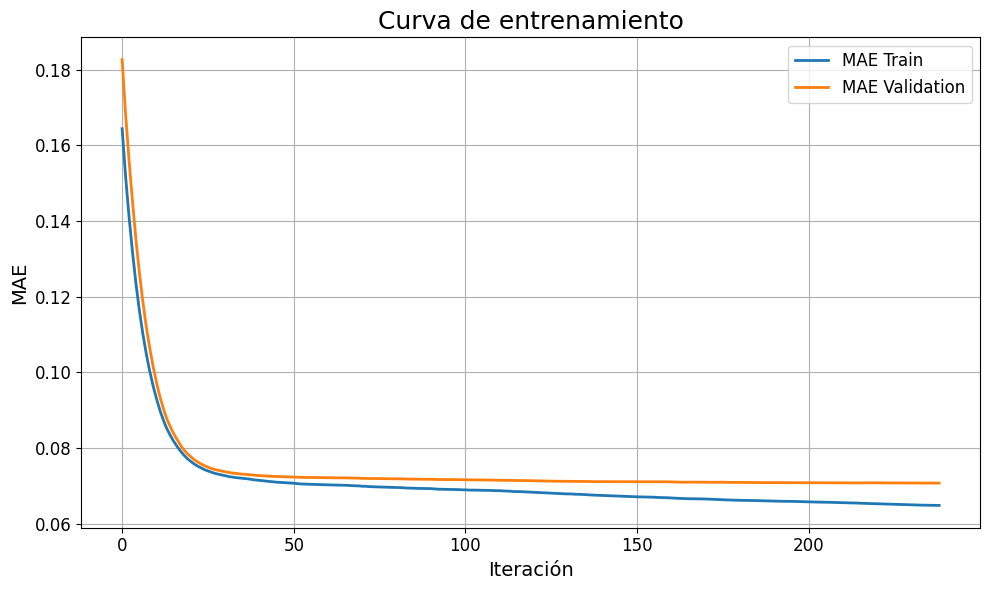

In [ ]:
evals_result = modelo_xgb.evals_result()

train_error = evals_result['validation_0']['mae']
val_error   = evals_result['validation_1']['mae']

plt.figure(figsize=(10, 6))

plt.plot(train_error, label='MAE Train', linewidth=2)
plt.plot(val_error, label='MAE Validation', linewidth=2)

plt.xlabel('Iteración', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.title('Curva de entrenamiento', fontsize=18)

plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
evaluar_estabilidad(X_train, y_train, X_val, y_val, X_test, y_test, mejores_params, n_iter=5)


Iteración 1, random_state=4608
----- TRAIN -----
MSE:  0.0101
RMSE: 0.1003
MAE:  0.0656
----- VAL -----
MSE:  0.0117
RMSE: 0.1080
MAE:  0.0707
----- TEST -----
MSE:  0.0107
RMSE: 0.1032
MAE:  0.0688

Iteración 2, random_state=8872
----- TRAIN -----
MSE:  0.0102
RMSE: 0.1008
MAE:  0.0660
----- VAL -----
MSE:  0.0116
RMSE: 0.1077
MAE:  0.0707
----- TEST -----
MSE:  0.0108
RMSE: 0.1038
MAE:  0.0692

Iteración 3, random_state=3006
----- TRAIN -----
MSE:  0.0101
RMSE: 0.1007
MAE:  0.0660
----- VAL -----
MSE:  0.0117
RMSE: 0.1081
MAE:  0.0709
----- TEST -----
MSE:  0.0106
RMSE: 0.1032
MAE:  0.0688

Iteración 4, random_state=7395
----- TRAIN -----
MSE:  0.0102
RMSE: 0.1008
MAE:  0.0661
----- VAL -----
MSE:  0.0117
RMSE: 0.1083
MAE:  0.0708
----- TEST -----
MSE:  0.0108
RMSE: 0.1037
MAE:  0.0691

Iteración 5, random_state=649
----- TRAIN -----
MSE:  0.0098
RMSE: 0.0992
MAE:  0.0648
----- VAL -----
MSE:  0.0117
RMSE: 0.1082
MAE:  0.0708
----- TEST -----
MSE:  0.0106
RMSE: 0.1031
MAE:  0.0687



np.float64(0.06891313844521027)

GRÁFICO REAL VS PREDICHO

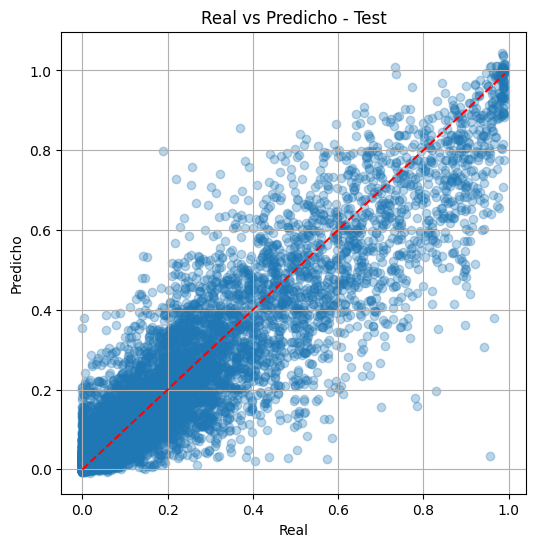

In [ ]:
import matplotlib.pyplot as plt

def plot_real_vs_pred(y_true, y_pred, title=""):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Real")
    plt.ylabel("Predicho")
    plt.title(f"Real vs Predicho - {title}")
    plt.grid(True)
    plt.show()

plot_real_vs_pred(y_test, y_pred_test, "Test")


RESIDUALES VS VALORES PREDICHOS

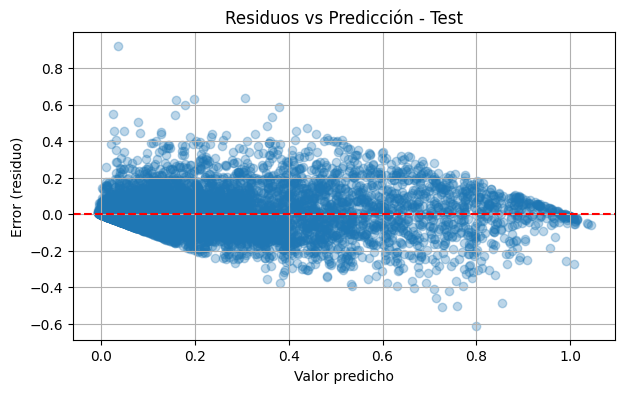

In [ ]:
def plot_residuos(y_true, y_pred, title=""):
    residuos = y_true - y_pred
    plt.figure(figsize=(7, 4))
    plt.scatter(y_pred, residuos, alpha=0.3)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Valor predicho")
    plt.ylabel("Error (residuo)")
    plt.title(f"Residuos vs Predicción - {title}")
    plt.grid(True)
    plt.show()

plot_residuos(y_test, y_pred_test, "Test")


In [ ]:
# Se observa que hay más error en los valores centrales, mientras que en los valores extremos nos equivocamos menos

IMPORTANCIA DE LAS VARIABLES

In [ ]:
pd.set_option('display.max_rows', None)
importancias = modelo_xgb.feature_importances_

df_importancia = pd.DataFrame({
    'feature': X_trainval.columns,
    'importancia': importancias
}).sort_values(by='importancia', ascending=False)

df_importancia

feature  importancia
87   mean_wind_cubed_lag0     0.207740
88   mean_wind_cubed_lag1     0.145418
82   mean_wind_speed_lag0     0.075739
83   mean_wind_speed_lag1     0.052902
86  mean_wind_cubed_lag-1     0.026170
81  mean_wind_speed_lag-1     0.024746
84   mean_wind_speed_lag2     0.019650
80  mean_wind_speed_lag-2     0.016098
89   mean_wind_cubed_lag2     0.015884
85  mean_wind_cubed_lag-2     0.015508
28     u100_punto_15_lag1     0.010053
70    v100_punto_16_lag-2     0.008902
91               cos_hora     0.008296
77      v100_punto_9_lag0     0.007321
31    u100_punto_16_lag-1     0.006925
21    u100_punto_14_lag-1     0.006905
71    v100_punto_16_lag-1     0.006755
29     u100_punto_15_lag2     0.006749
78      v100_punto_9_lag1     0.006653
65    v100_punto_15_lag-2     0.006543
27     u100_punto_15_lag0     0.006411
60    v100_punto_14_lag-2     0.006343
92                 verano     0.006254
9      u100_punto_11_lag2     0.006116
61    v100_punto_14_lag-1     0.006051
47     v100_punto_11_lag0     0.006038
18     u100_punto_13_lag1     0.006025
73     v100_punto_16_lag1     0.005974
62     v100_punto_14_lag0     0.005941
90               sin_hora     0.005786
13     u100_punto_12_lag1     0.005760
67     v100_punto_15_lag0     0.005651
50    v100_punto_12_lag-2     0.005632
41    v100_punto_10_lag-1     0.005576
25    u100_punto_15_lag-2     0.005444
52     v100_punto_12_lag0     0.005416
75     v100_punto_9_lag-2     0.005348
72     v100_punto_16_lag0     0.005344
33     u100_punto_16_lag1     0.005228
59     v100_punto_13_lag2     0.005135
45    v100_punto_11_lag-2     0.004951
64     v100_punto_14_lag2     0.004883
17     u100_punto_13_lag0     0.004865
74     v100_punto_16_lag2     0.004857
40    v100_punto_10_lag-2     0.004824
32     u100_punto_16_lag0     0.004823
20    u100_punto_14_lag-2     0.004787
15    u100_punto_13_lag-2     0.004731
76     v100_punto_9_lag-1     0.004686
12     u100_punto_12_lag0     0.004660
22     u100_punto_14_lag0     0.004462
5     u100_punto_11_lag-2     0.004459
10    u100_punto_12_lag-2     0.004453
55    v100_punto_13_lag-2     0.004405
19     u100_punto_13_lag2     0.004383
54     v100_punto_12_lag2     0.004354
7      u100_punto_11_lag0     0.004352
11    u100_punto_12_lag-1     0.004322
36     u100_punto_9_lag-1     0.004203
34     u100_punto_16_lag2     0.004125
56    v100_punto_13_lag-1     0.004071
38      u100_punto_9_lag1     0.004052
37      u100_punto_9_lag0     0.004035
23     u100_punto_14_lag1     0.004025
66    v100_punto_15_lag-1     0.004024
68     v100_punto_15_lag1     0.004007
14     u100_punto_12_lag2     0.004003
63     v100_punto_14_lag1     0.003914
39      u100_punto_9_lag2     0.003889
57     v100_punto_13_lag0     0.003884
43     v100_punto_10_lag1     0.003871
8      u100_punto_11_lag1     0.003845
16    u100_punto_13_lag-1     0.003785
4      u100_punto_10_lag2     0.003759
24     u100_punto_14_lag2     0.003740
79      v100_punto_9_lag2     0.003702
6     u100_punto_11_lag-1     0.003670
51    v100_punto_12_lag-1     0.003608
69     v100_punto_15_lag2     0.003591
58     v100_punto_13_lag1     0.003580
30    u100_punto_16_lag-2     0.003542
44     v100_punto_10_lag2     0.003501
26    u100_punto_15_lag-1     0.003388
35     u100_punto_9_lag-2     0.003364
42     v100_punto_10_lag0     0.003342
49     v100_punto_11_lag2     0.003250
3      u100_punto_10_lag1     0.003234
53     v100_punto_12_lag1     0.003206
46    v100_punto_11_lag-1     0.003164
2      u100_punto_10_lag0     0.003104
48     v100_punto_11_lag1     0.002927
1     u100_punto_10_lag-1     0.002513
0     u100_punto_10_lag-2     0.002395

Parece como si solo fuesen importantes las medias, pruebo quitando las medias a ver qué metricas salen y cómo es la importancia de las variables.

In [ ]:
pd.reset_option('display.max_rows')

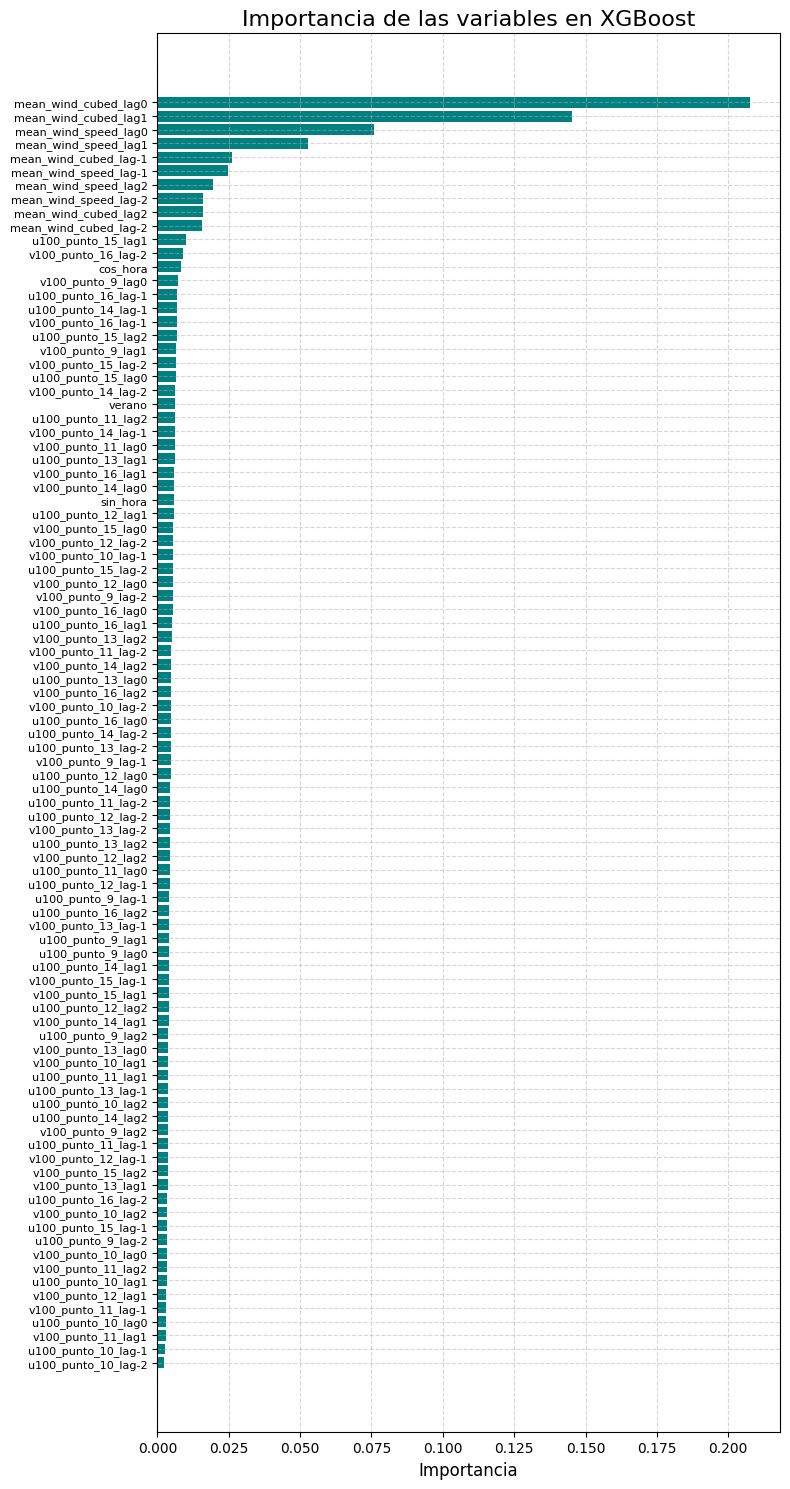

In [ ]:
plt.figure(figsize=(8, 15))
plt.barh(df_importancia['feature'], df_importancia['importancia'], color='teal')
plt.xlabel('Importancia', fontsize=12)
plt.title('Importancia de las variables en XGBoost', fontsize=16)
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.5)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


<ipython-input-48-bca6d6cdbb81>:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


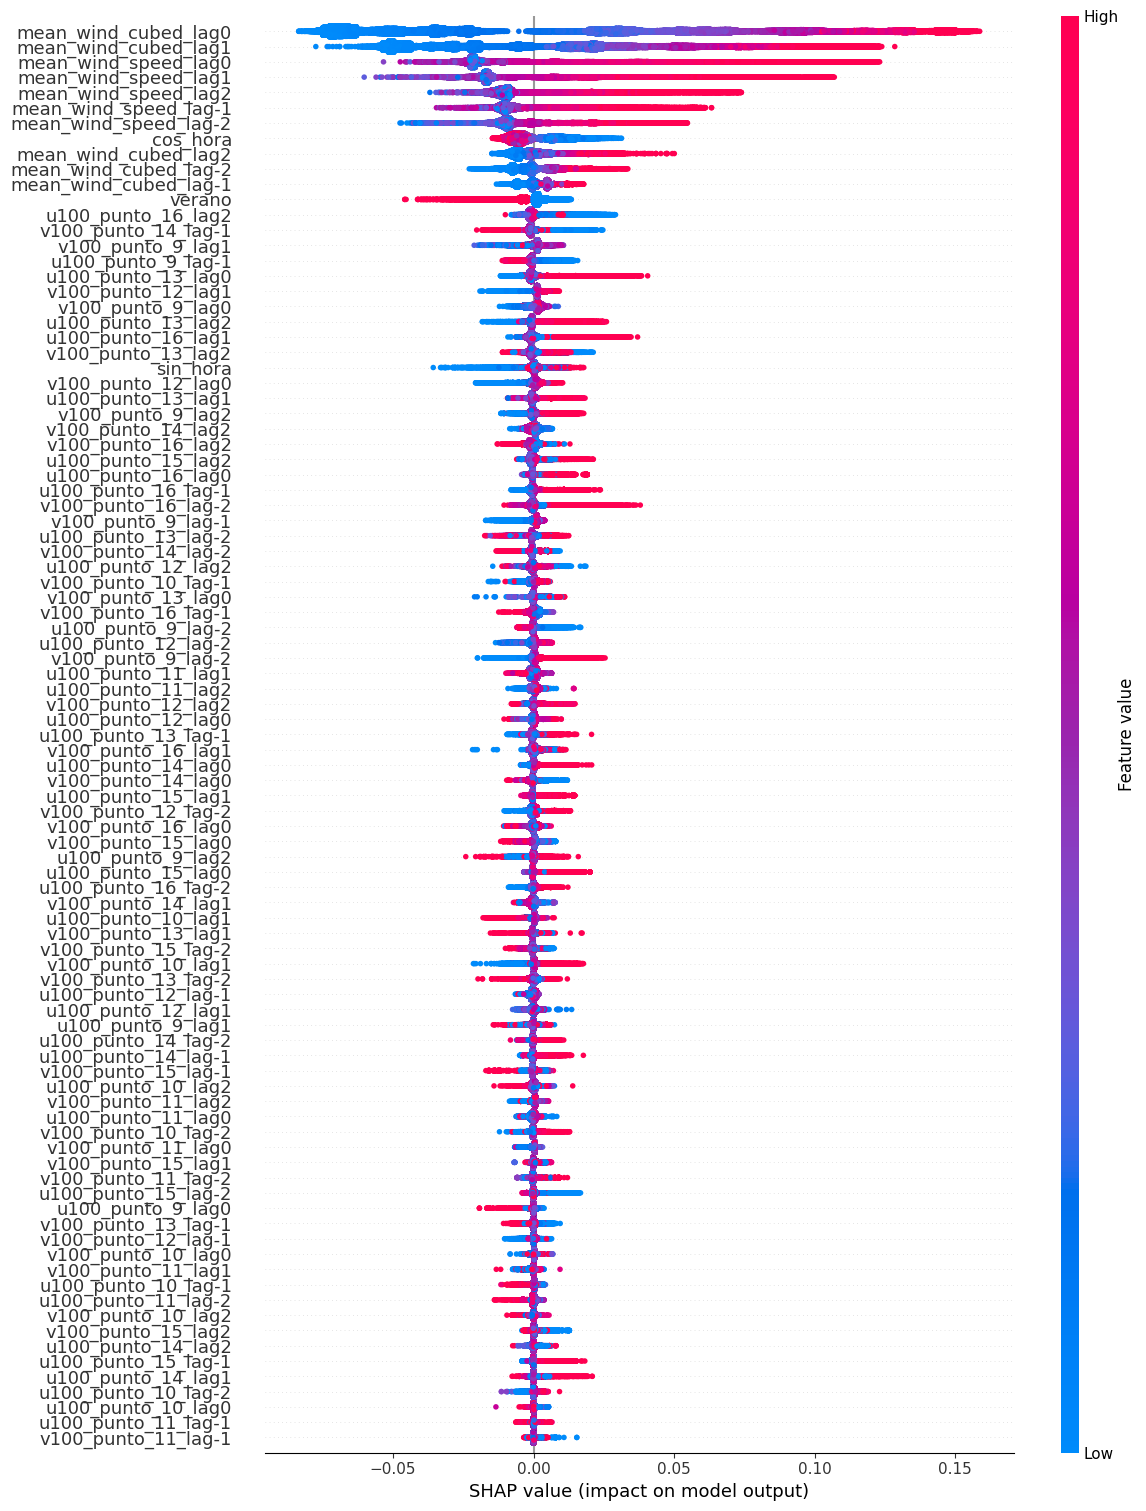

In [ ]:
explainer = shap.TreeExplainer(modelo_xgb)
shap_values = explainer.shap_values(X_trainval)
plt.rcParams.update({'font.size': 3})
shap.summary_plot(
    shap_values,
    X_trainval,
    max_display=100,
    plot_size=(12, 15)
)

## Optuna sobre el modelo escogido (solo parámetros)

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.7 MB/s eta 0:00:00


In [ ]:
def objective(trial):

    params = {
        'objective': 'reg:absoluteerror',
        'booster': 'gbtree',
        'tree_method': 'hist',
        'learning_rate': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_estimators': 10000,
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'early_stopping_rounds': 10,
        'gamma': trial.suggest_float('gamma', 0.0, 10.0)
    }

    maes = []
    for i in range(5):
        params['random_state'] = np.random.randint(0, 10000)

        modelo = xgb.XGBRegressor(**params)

        modelo.fit(
            X_train[variables_predictoras],
            y_train,
            eval_set=[(X_val[variables_predictoras], y_val)],
            verbose=False
        )

        y_pred = modelo.predict(X_val[variables_predictoras])
        mae = mean_absolute_error(y_val, y_pred)
        maes.append(mae)

    return np.mean(maes)

In [ ]:
study = optuna.create_study(
    direction='minimize',
    study_name='Xgboost parámetros finales',
    storage='sqlite:///optuna_estudio_xgb_param (2).db',
    load_if_exists=True
)

study.optimize(objective, n_trials=100)
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print("Mejor MAE de validación: ", study.best_value)


[I 2025-05-29 20:45:49,304] Using an existing study with name 'Xgboost parámetros finales' instead of creating a new one.
[I 2025-05-29 20:49:39,256] Trial 98 finished with value: 0.06699332668958632 and parameters: {'eta': 0.012564144725473599, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 8.428043960604729, 'reg_lambda': 0.8792722840943128, 'subsample': 0.5106211474428765, 'colsample_bytree': 0.6266971991893908, 'gamma': 3.8003144045774464}. Best is trial 53 with value: 0.066908195035612.
[I 2025-05-29 20:52:49,341] Trial 99 finished with value: 0.06702718509526713 and parameters: {'eta': 0.01594527292890234, 'max_depth': 10, 'min_child_weight': 2, 'reg_alpha': 9.601027811982002, 'reg_lambda': 2.3633840560909016, 'subsample': 0.5741586117988123, 'colsample_bytree': 0.6082327854353695, 'gamma': 4.259979432838904}. Best is trial 53 with value: 0.066908195035612.
[I 2025-05-29 20:53:13,802] Trial 100 finished with value: 0.06886264344561961 and parameters: {'eta': 0.23641494034515

Mejores hiperparámetros encontrados:
{'eta': 0.011331936798838026, 'max_depth': 9, 'min_child_weight': 4, 'reg_alpha': 9.593559280073505, 'reg_lambda': 4.5380926181104435, 'subsample': 0.5321800618365685, 'colsample_bytree': 0.5774166682740726, 'gamma': 4.356061803723409}
Mejor MAE de validación:  0.066908195035612


In [ ]:
best_trial = study.best_trial

In [ ]:
print("Mejor MAE obtenido:", best_trial.value)
print("Mejores hiperparámetros:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

Mejor MAE obtenido: 0.07044944011009883
Mejores hiperparámetros:
  eta: 0.029582794946057218
  max_depth: 9
  min_child_weight: 1
  reg_alpha: 6.038554436591245
  reg_lambda: 5.967601604357434
  subsample: 0.6896650350410986
  colsample_bytree: 0.6655461904070257


In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]
train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43400 filas
Val: 7600 filas


In [ ]:
mejores_params ={'booster': 'gbtree', 'colsample_bytree': 0.5774166682740726, 'gamma': 4.356061803723409,
                 'learning_rate': 0.011331936798838026,'max_depth': 9, 'min_child_weight': 4, 'reg_alpha': 9.593559280073505,
                 'reg_lambda': 4.5380926181104435,'subsample': 0.5321800618365685, 'tree_method': 'hist','n_estimators': 10000}

In [ ]:
maes_test= evaluar_estabilidad(
    X_train, y_train, X_val, y_val, X_test, y_test,
    mejores_params, n_iter=10
)


Iteración 1, random_state=8645
----- TRAIN -----
MSE:  0.0094
RMSE: 0.0971
MAE:  0.0627
----- VAL -----
MSE:  0.0116
RMSE: 0.1077
MAE:  0.0705
----- TEST -----
MSE:  0.0106
RMSE: 0.1029
MAE:  0.0685

Iteración 2, random_state=3801
----- TRAIN -----
MSE:  0.0095
RMSE: 0.0973
MAE:  0.0631
----- VAL -----
MSE:  0.0116
RMSE: 0.1075
MAE:  0.0705
----- TEST -----
MSE:  0.0106
RMSE: 0.1028
MAE:  0.0685

Iteración 3, random_state=2959
----- TRAIN -----
MSE:  0.0094
RMSE: 0.0971
MAE:  0.0628
----- VAL -----
MSE:  0.0116
RMSE: 0.1075
MAE:  0.0704
----- TEST -----
MSE:  0.0105
RMSE: 0.1026
MAE:  0.0683

Iteración 4, random_state=7821
----- TRAIN -----
MSE:  0.0094
RMSE: 0.0970
MAE:  0.0626
----- VAL -----
MSE:  0.0116
RMSE: 0.1076
MAE:  0.0704
----- TEST -----
MSE:  0.0105
RMSE: 0.1026
MAE:  0.0683

Iteración 5, random_state=1425
----- TRAIN -----
MSE:  0.0094
RMSE: 0.0972
MAE:  0.0629
----- VAL -----
MSE:  0.0116
RMSE: 0.1075
MAE:  0.0704
----- TEST -----
MSE:  0.0106
RMSE: 0.1027
MAE:  0.0684


0.06844 ± 0.00011

## OPTUNA (parámetros y variables)

En cada trial, se escoge un conjunto de variables variables predictoras fijo, y se prueba el modelo 10 veces cambiando solo la semilla del modelo, no la selección de variables.


In [ ]:
pip install optuna

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]
train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

Train: 43500 filas
Val: 7600 filas


- Añado la restricción de que solo pueda selecciona o no selecciona las variables sin y cos hora conjuntamente, ya que solo una de las dos no representa correctamente la posición en el ciclo.
El par (sin, cos) juntos codifican una posición única en una circunferencia.

In [ ]:
def objective(trial):

    # Selección normal de variables predictoras, excluyendo sin_hora y cos_hora
    selected_features = [
        var for var in variables_predictoras
        if var not in ['sin_hora', 'cos_hora'] and trial.suggest_categorical(var, [True, False])
    ]

    # Se fuerza a que escoja las var sin_hora y cos_hora conjuntamente o que no las coja
    if trial.suggest_categorical(f"use_{'hora'}", [True, False]):
        selected_features = selected_features + ['sin_hora', 'cos_hora']

    if len(selected_features) == 0:
        return float('inf')

    params = {
        'objective': 'reg:absoluteerror',
        'booster': 'gbtree',
        'tree_method': 'hist',
        'learning_rate': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_estimators': 10000,
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'early_stopping_rounds': 10,
        'gamma': trial.suggest_float('gamma', 0.0, 10.0)
    }

    maes = []
    for i in range(5):
        params['random_state'] = np.random.randint(0, 10000)

        modelo = xgb.XGBRegressor(**params)

        modelo.fit(
            X_train[selected_features],
            y_train,
            eval_set=[(X_val[selected_features], y_val)],
            verbose=False
        )

        y_pred = modelo.predict(X_val[selected_features])
        mae = mean_absolute_error(y_val, y_pred)
        maes.append(mae)

    return np.mean(maes)

In [ ]:
import optuna

study = optuna.create_study(
    direction='minimize',
    study_name='Xgboost parámetros y variables',
    storage='sqlite:///optuna_estudio_xgb_param_var.db',
    load_if_exists=True
)

study.optimize(objective, n_trials=150)


print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print("Mejor MAE de validación: ", study.best_value)
files.download('optuna_estudio_xgb_param_var.db')


[I 2025-05-30 15:55:54,280] A new study created in RDB with name: Xgboost parámetros y variables
[I 2025-05-30 15:58:37,770] Trial 0 finished with value: 0.06964924069195011 and parameters: {'u100_punto_10_lag-2': True, 'u100_punto_10_lag-1': True, 'u100_punto_10_lag0': False, 'u100_punto_10_lag1': False, 'u100_punto_10_lag2': False, 'u100_punto_11_lag-2': False, 'u100_punto_11_lag-1': True, 'u100_punto_11_lag0': False, 'u100_punto_11_lag1': True, 'u100_punto_11_lag2': False, 'u100_punto_12_lag-2': True, 'u100_punto_12_lag-1': True, 'u100_punto_12_lag0': True, 'u100_punto_12_lag1': False, 'u100_punto_12_lag2': True, 'u100_punto_13_lag-2': True, 'u100_punto_13_lag-1': True, 'u100_punto_13_lag0': True, 'u100_punto_13_lag1': True, 'u100_punto_13_lag2': False, 'u100_punto_14_lag-2': False, 'u100_punto_14_lag-1': True, 'u100_punto_14_lag0': True, 'u100_punto_14_lag1': True, 'u100_punto_14_lag2': False, 'u100_punto_15_lag-2': True, 'u100_punto_15_lag-1': False, 'u100_punto_15_lag0': True, 'u

Mejores hiperparámetros encontrados:
{'u100_punto_10_lag-2': False, 'u100_punto_10_lag-1': False, 'u100_punto_10_lag0': False, 'u100_punto_10_lag1': True, 'u100_punto_10_lag2': False, 'u100_punto_11_lag-2': True, 'u100_punto_11_lag-1': True, 'u100_punto_11_lag0': False, 'u100_punto_11_lag1': False, 'u100_punto_11_lag2': True, 'u100_punto_12_lag-2': True, 'u100_punto_12_lag-1': False, 'u100_punto_12_lag0': True, 'u100_punto_12_lag1': True, 'u100_punto_12_lag2': False, 'u100_punto_13_lag-2': True, 'u100_punto_13_lag-1': False, 'u100_punto_13_lag0': False, 'u100_punto_13_lag1': False, 'u100_punto_13_lag2': True, 'u100_punto_14_lag-2': True, 'u100_punto_14_lag-1': False, 'u100_punto_14_lag0': False, 'u100_punto_14_lag1': False, 'u100_punto_14_lag2': False, 'u100_punto_15_lag-2': False, 'u100_punto_15_lag-1': True, 'u100_punto_15_lag0': False, 'u100_punto_15_lag1': False, 'u100_punto_15_lag2': False, 'u100_punto_16_lag-2': False, 'u100_punto_16_lag-1': True, 'u100_punto_16_lag0': True, 'u10

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Definición y evaluación del modelo final

In [10]:
variables_predictoras =  ['u100_punto_10_lag1',
             'u100_punto_11_lag-2',
             'u100_punto_11_lag-1',
             'u100_punto_11_lag2',
             'u100_punto_12_lag-2',
             'u100_punto_12_lag0',
             'u100_punto_12_lag1',
             'u100_punto_13_lag-2',
             'u100_punto_13_lag2',
             'u100_punto_14_lag-2',
             'u100_punto_15_lag-1',
             'u100_punto_16_lag-1',
             'u100_punto_16_lag0',
             'u100_punto_16_lag1',
             'u100_punto_16_lag2',
             'u100_punto_9_lag-1',
             'u100_punto_9_lag0',
             'v100_punto_10_lag-2',
             'v100_punto_10_lag-1',
             'v100_punto_11_lag-1',
             'v100_punto_11_lag0',
             'v100_punto_11_lag2',
             'v100_punto_12_lag-2',
             'v100_punto_12_lag-1',
             'v100_punto_12_lag1',
             'v100_punto_13_lag-2',
             'v100_punto_13_lag-1',
             'v100_punto_13_lag1',
             'v100_punto_13_lag2',
             'v100_punto_14_lag-2',
             'v100_punto_14_lag-1',
             'v100_punto_15_lag-1',
             'v100_punto_15_lag2',
             'v100_punto_16_lag-2',
             'v100_punto_16_lag-1',
            'v100_punto_16_lag0',
            'v100_punto_9_lag-2',
            'v100_punto_9_lag-1',
            'v100_punto_9_lag1',
            'mean_wind_speed_lag-2',
            'mean_wind_speed_lag-1',
            'mean_wind_speed_lag0',
            'mean_wind_cubed_lag-2',
            'mean_wind_cubed_lag-1',
            'mean_wind_cubed_lag0',
            'mean_wind_cubed_lag1',
            'mean_wind_cubed_lag2',
            'verano',
            'cos_hora', 'sin_hora'
]

In [11]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [14]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]
train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

In [15]:
mejores_params ={'booster': 'gbtree', 'colsample_bytree': 0.9226958075139056, 'gamma': 3.3042117927232244, 'learning_rate': 0.014737200478100673,
 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 9.303370212547152, 'reg_lambda': 0.8485082821324884,
                 'subsample': 0.5551226865712834, 'tree_method': 'hist','n_estimators': 10000}


In [ ]:
maes_test= evaluar_estabilidad(
    X_train, y_train, X_val, y_val, X_test, y_test,
    mejores_params, n_iter=5
)


Iteración 1, random_state=9169
----- TRAIN -----
MSE:  0.0093
RMSE: 0.0967
MAE:  0.0621
----- VAL -----
MSE:  0.0103
RMSE: 0.1016
MAE:  0.0669
----- TEST -----
MSE:  0.0105
RMSE: 0.1024
MAE:  0.0683

Iteración 2, random_state=9888
----- TRAIN -----
MSE:  0.0093
RMSE: 0.0966
MAE:  0.0621
----- VAL -----
MSE:  0.0104
RMSE: 0.1018
MAE:  0.0670
----- TEST -----
MSE:  0.0105
RMSE: 0.1024
MAE:  0.0682

Iteración 3, random_state=6238
----- TRAIN -----
MSE:  0.0092
RMSE: 0.0957
MAE:  0.0611
----- VAL -----
MSE:  0.0104
RMSE: 0.1018
MAE:  0.0670
----- TEST -----
MSE:  0.0105
RMSE: 0.1023
MAE:  0.0682

Iteración 4, random_state=4538
----- TRAIN -----
MSE:  0.0092
RMSE: 0.0960
MAE:  0.0614
----- VAL -----
MSE:  0.0104
RMSE: 0.1018
MAE:  0.0671
----- TEST -----
MSE:  0.0105
RMSE: 0.1024
MAE:  0.0683

Iteración 5, random_state=4236
----- TRAIN -----
MSE:  0.0094
RMSE: 0.0968
MAE:  0.0623
----- VAL -----
MSE:  0.0104
RMSE: 0.1018
MAE:  0.0671
----- TEST -----
MSE:  0.0105
RMSE: 0.1027
MAE:  0.0685


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import random
import xgboost as xgb

def calcular_metricas(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

def evaluar_estabilidad_xgb(X_train, y_train, X_val, y_val, X_test, y_test, mejores_params, n_iter=5):
    # Diccionarios para acumular métricas
    metricas = {
        "train": {"mse": [], "rmse": [], "mae": [], "r2": []},
        "val":   {"mse": [], "rmse": [], "mae": [], "r2": []},
        "test":  {"mse": [], "rmse": [], "mae": [], "r2": []}
    }

    for i in range(n_iter):
        semilla = random.randint(0, 10000)
        modelo_xgb = xgb.XGBRegressor(
            objective='reg:absoluteerror',
            random_state=semilla,
            early_stopping_rounds=10,
            **mejores_params
        )
        modelo_xgb.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        # Predicciones
        y_preds = {
            "train": modelo_xgb.predict(X_train),
            "val":   modelo_xgb.predict(X_val),
            "test":  modelo_xgb.predict(X_test)
        }

        print(f"\n🔁 Iteración {i+1}, random_state={semilla}")
        for conjunto in ["train", "val", "test"]:
            y_true = {"train": y_train, "val": y_val, "test": y_test}[conjunto]
            y_pred = y_preds[conjunto]
            mse, rmse, mae, r2 = calcular_metricas(y_true, y_pred)

            metricas[conjunto]["mse"].append(mse)
            metricas[conjunto]["rmse"].append(rmse)
            metricas[conjunto]["mae"].append(mae)
            metricas[conjunto]["r2"].append(r2)

            print(f"----- {conjunto.upper()} -----")
            print(f"MSE:  {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

    # Resumen final
    print("\n📊 Promedios ± Desviaciones:")
    filas = []
    for conjunto in ["train", "val", "test"]:
        print(f"\n👉 {conjunto.upper()}")
        for metrica in ["mse", "rmse", "mae", "r2"]:
            valores = metricas[conjunto][metrica]
            media = np.mean(valores)
            std = np.std(valores)
            print(f"{metrica.upper()}: {media:.5f} ± {std:.5f}")
            filas.append({
                "conjunto": conjunto,
                "metrica": metrica,
                "media": media,
                "std": std
            })

    resumen_df = pd.DataFrame(filas)
    return resumen_df


In [ ]:
resumen_df= evaluar_estabilidad_xgb(
    X_train, y_train, X_val, y_val, X_test, y_test,
    mejores_params, n_iter=5
)


🔁 Iteración 1, random_state=2126
----- TRAIN -----
MSE:  0.0092 | RMSE: 0.0957 | MAE: 0.0611 | R²: 0.8475
----- VAL -----
MSE:  0.0104 | RMSE: 0.1018 | MAE: 0.0669 | R²: 0.8318
----- TEST -----
MSE:  0.0105 | RMSE: 0.1025 | MAE: 0.0683 | R²: 0.8289

🔁 Iteración 2, random_state=792
----- TRAIN -----
MSE:  0.0091 | RMSE: 0.0956 | MAE: 0.0610 | R²: 0.8479
----- VAL -----
MSE:  0.0103 | RMSE: 0.1017 | MAE: 0.0669 | R²: 0.8321
----- TEST -----
MSE:  0.0105 | RMSE: 0.1023 | MAE: 0.0681 | R²: 0.8297

🔁 Iteración 3, random_state=239
----- TRAIN -----
MSE:  0.0092 | RMSE: 0.0958 | MAE: 0.0613 | R²: 0.8471
----- VAL -----
MSE:  0.0104 | RMSE: 0.1018 | MAE: 0.0670 | R²: 0.8317
----- TEST -----
MSE:  0.0105 | RMSE: 0.1024 | MAE: 0.0682 | R²: 0.8293

🔁 Iteración 4, random_state=2898
----- TRAIN -----
MSE:  0.0092 | RMSE: 0.0958 | MAE: 0.0612 | R²: 0.8472
----- VAL -----
MSE:  0.0104 | RMSE: 0.1019 | MAE: 0.0670 | R²: 0.8315
----- TEST -----
MSE:  0.0105 | RMSE: 0.1023 | MAE: 0.0681 | R²: 0.8296

🔁

A partir de ahora, defino el modelo fijando la semilla para que así los resultados sean reproducibles:

In [17]:
modelo_xgb = xgb.XGBRegressor(
            objective='reg:absoluteerror',
            random_state=42,
            early_stopping_rounds=10,
            **mejores_params
        )

modelo_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9226958075139056, device=None,
             early_stopping_rounds=10, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=3.3042117927232244,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.014737200478100673,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

In [18]:
# Predicciones
y_pred_train = modelo_xgb.predict(X_train)
y_pred_val   = modelo_xgb.predict(X_val)
y_pred_test  = modelo_xgb.predict(X_test)

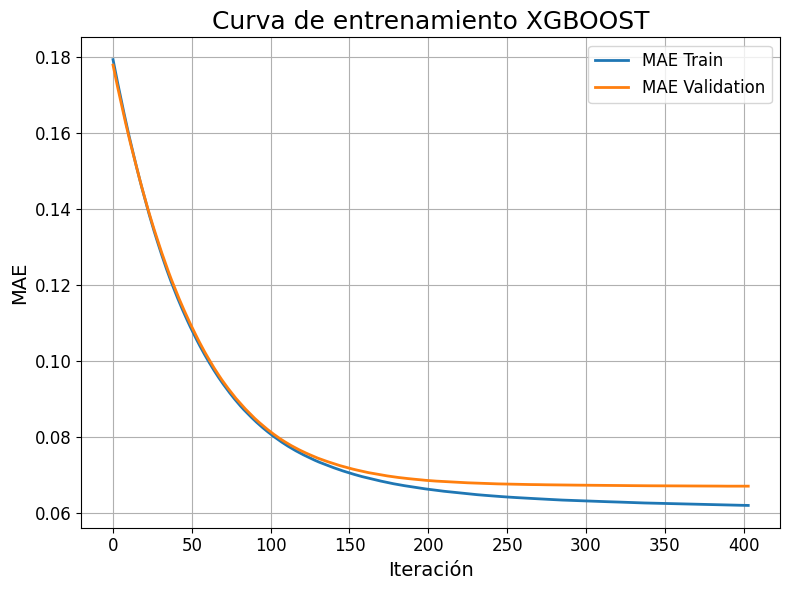

In [19]:
evals_result = modelo_xgb.evals_result()

train_error = evals_result['validation_0']['mae']
val_error   = evals_result['validation_1']['mae']

plt.figure(figsize=(8, 6))

plt.plot(train_error, label='MAE Train', linewidth=2)
plt.plot(val_error, label='MAE Validation', linewidth=2)

plt.xlabel('Iteración', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.title('Curva de entrenamiento XGBOOST', fontsize=18)

plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

GRÁFICO REAL VS PREDICHO

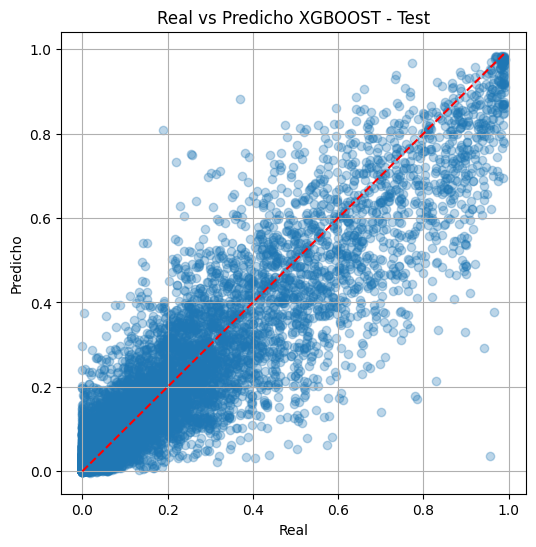

In [ ]:
import matplotlib.pyplot as plt

def plot_real_vs_pred(y_true, y_pred, title=""):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Real")
    plt.ylabel("Predicho")
    plt.title(f"Real vs Predicho XGBOOST - {title}")
    plt.grid(True)
    plt.show()

plot_real_vs_pred(y_test, y_pred_test, "Test")


RESIDUALES VS VALORES PREDICHOS

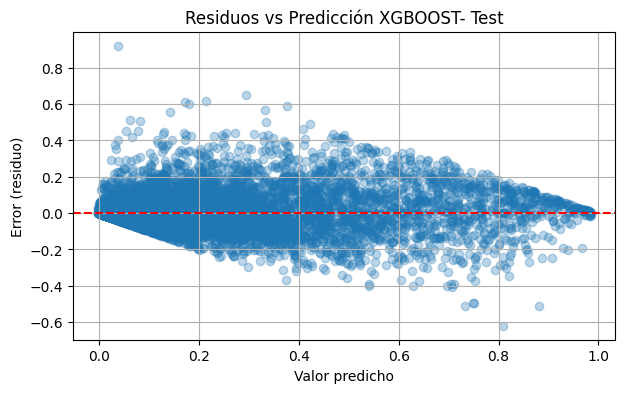

In [ ]:
def plot_residuos(y_true, y_pred, title=""):
    residuos = y_true - y_pred
    plt.figure(figsize=(7, 4))
    plt.scatter(y_pred, residuos, alpha=0.3)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Valor predicho")
    plt.ylabel("Error (residuo)")
    plt.title(f"Residuos vs Predicción XGBOOST  - {title}")
    plt.grid(True)
    plt.show()

plot_residuos(y_test, y_pred_test, "Test")


In [ ]:
# Se observa que hay más error en los valores centrales, mientras que en los valores extremos nos equivocamos menos

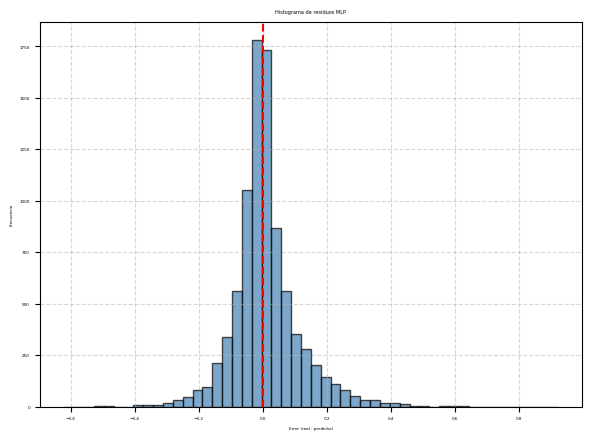

In [ ]:
residuos_train = y_train - y_pred_train
residuos_val   = y_val - y_pred_val
residuos_test  = y_test - y_pred_test

plt.figure(figsize=(7, 5))
plt.hist(residuos_test, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Histograma de residuos MLP")
plt.xlabel("Error (real - predicho)")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


IMPORTANCIA DE LAS VARIABLES

In [ ]:
pd.set_option('display.max_rows', None)
importancias = modelo_xgb.feature_importances_
df_importancia = pd.DataFrame({
    'feature': X_trainval.columns,
    'importancia': importancias
}).sort_values(by='importancia', ascending=False)

df_importancia

feature  importancia
44   mean_wind_cubed_lag0     0.358063
41   mean_wind_speed_lag0     0.179557
45   mean_wind_cubed_lag1     0.134218
46   mean_wind_cubed_lag2     0.018561
40  mean_wind_speed_lag-1     0.016784
43  mean_wind_cubed_lag-1     0.013085
39  mean_wind_speed_lag-2     0.011441
42  mean_wind_cubed_lag-2     0.008714
48               cos_hora     0.007708
29    v100_punto_14_lag-2     0.007017
47                 verano     0.006956
17    v100_punto_10_lag-2     0.006878
13     u100_punto_16_lag1     0.006847
20     v100_punto_11_lag0     0.006830
8      u100_punto_13_lag2     0.006751
19    v100_punto_11_lag-1     0.006743
22    v100_punto_12_lag-2     0.006704
30    v100_punto_14_lag-1     0.006648
10    u100_punto_15_lag-1     0.006610
11    u100_punto_16_lag-1     0.006604
12     u100_punto_16_lag0     0.006558
33    v100_punto_16_lag-2     0.006516
35     v100_punto_16_lag0     0.006506
34    v100_punto_16_lag-1     0.006461
36     v100_punto_9_lag-2     0.006387
24     v100_punto_12_lag1     0.006235
9     u100_punto_14_lag-2     0.006223
38      v100_punto_9_lag1     0.006209
7     u100_punto_13_lag-2     0.006130
14     u100_punto_16_lag2     0.006104
2     u100_punto_11_lag-1     0.006013
28     v100_punto_13_lag2     0.005973
26    v100_punto_13_lag-1     0.005879
32     v100_punto_15_lag2     0.005856
6      u100_punto_12_lag1     0.005804
25    v100_punto_13_lag-2     0.005768
49               sin_hora     0.005760
31    v100_punto_15_lag-1     0.005750
0      u100_punto_10_lag1     0.005749
3      u100_punto_11_lag2     0.005734
23    v100_punto_12_lag-1     0.005715
27     v100_punto_13_lag1     0.005648
16      u100_punto_9_lag0     0.005609
37     v100_punto_9_lag-1     0.005609
5      u100_punto_12_lag0     0.005606
4     u100_punto_12_lag-2     0.005584
21     v100_punto_11_lag2     0.005556
1     u100_punto_11_lag-2     0.005463
15     u100_punto_9_lag-1     0.005461
18    v100_punto_10_lag-1     0.005414

Parece como si solo fuesen importantes las medias, pruebo quitando las medias a ver qué metricas salen y cómo es la importancia de las variables.

In [21]:
pd.reset_option('display.max_rows')

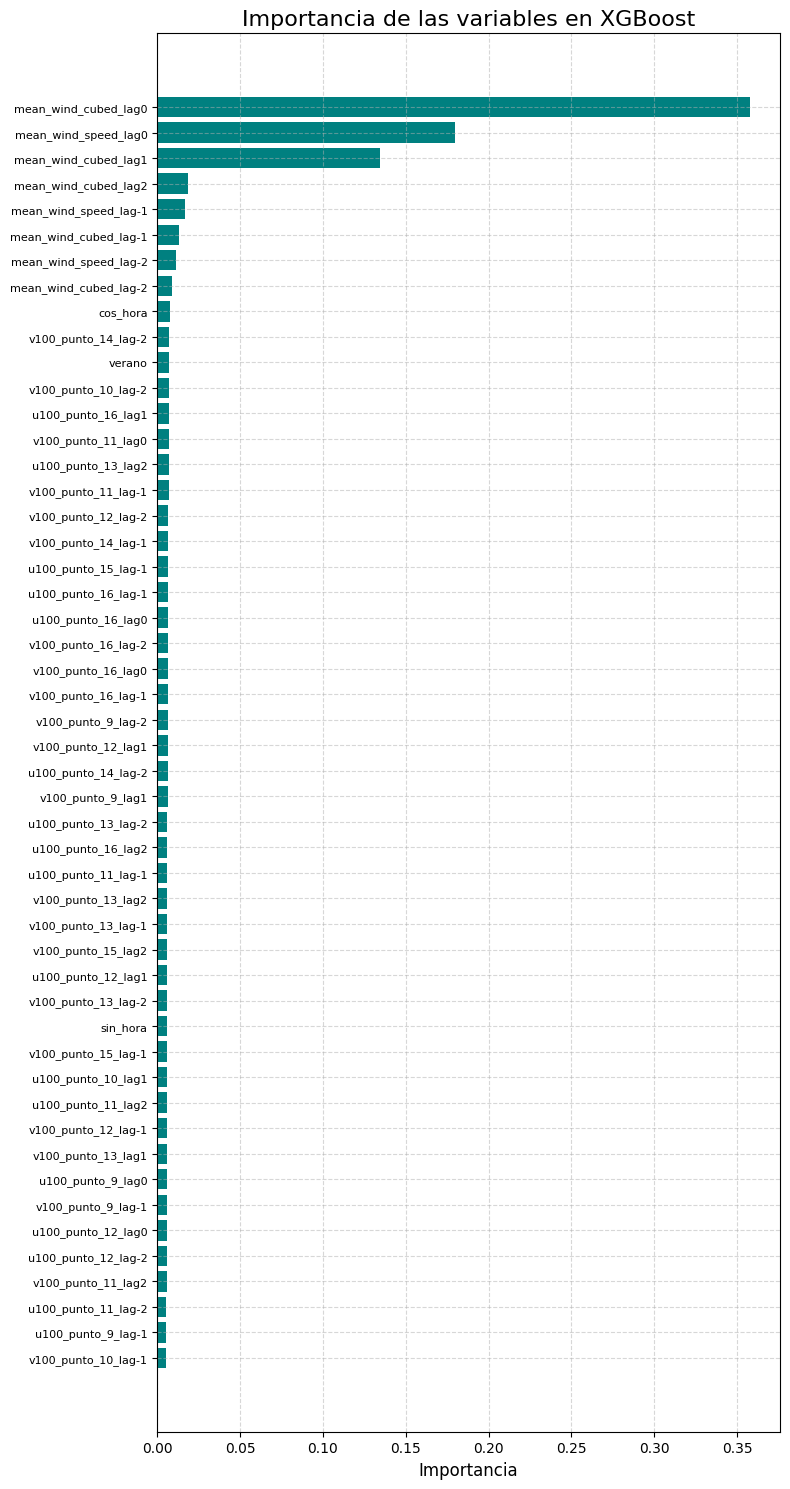

In [ ]:
plt.figure(figsize=(8, 15))
plt.barh(df_importancia['feature'], df_importancia['importancia'], color='teal')
plt.xlabel('Importancia', fontsize=12)
plt.title('Importancia de las variables en XGBoost', fontsize=16)
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.5)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


In [22]:
shap_values = explainer.shap_values(X_val)
plt.rcParams.update({'font.size': 3})

<ipython-input-23-2253893863>:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


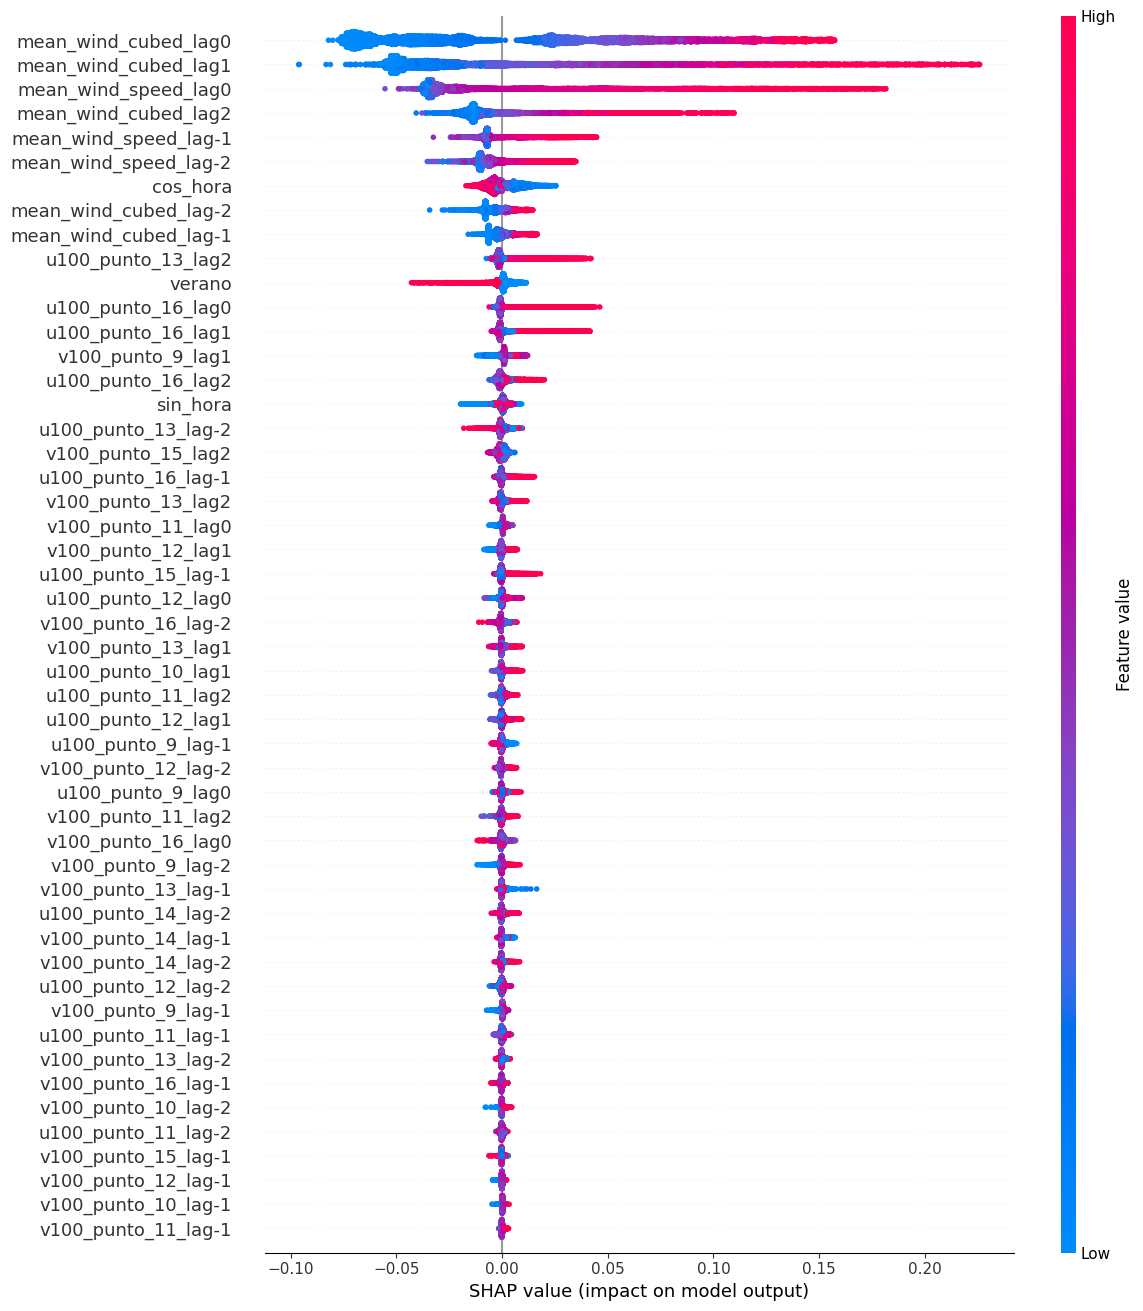

In [23]:
shap.summary_plot(
    shap_values,
    X_val,
    max_display=100,
    plot_size=(12, 13)
)

<ipython-input-25-3240469298>:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


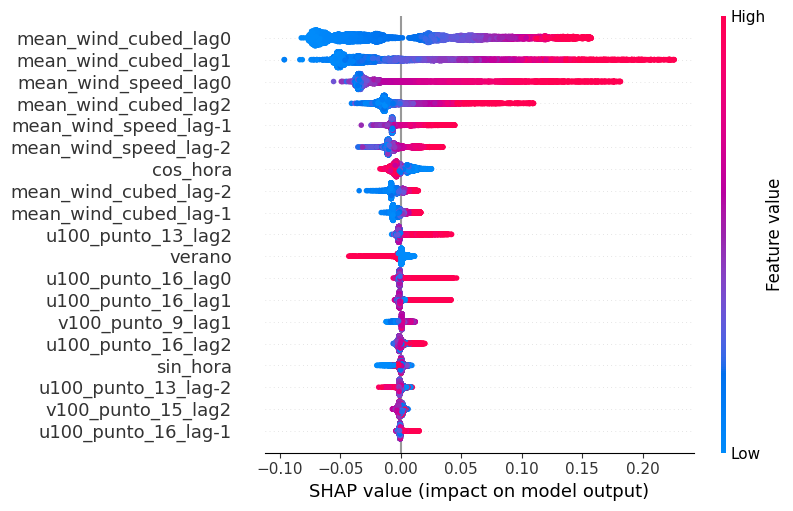

In [25]:
shap.summary_plot(
    shap_values,
    X_val,
    max_display=19,  # mostrar las 100 variables
    plot_size=(8, 5)  # ancho x alto en pulgadas
)

## PRUEBO SIN MEDIAS

Para evaluar la robustez del modelo y la relevancia real de las variables agregadas, se entrenó una versión alternativa del modelo eliminando las variables de media de velocidad y velocidad al cubo, que son las que tenían una mayor importancia. Se observó una ligera degradación en el rendimiento, lo que confirma que dichas variables resumen información relevante de forma eficaz pero también indican la robustez del modelo. Además, al eliminar estas variables, la importancia del modelo se redistribuyó entre múltiples variables individuales, lo que indica que la información seguía presente pero de forma más dispersa. Este análisis refuerza la elección del modelo original, que no solo ofrece mejor precisión, sino también una representación más compacta y fácilmente interpretable de los datos relevantes.

In [26]:
variables_predictoras =  ['u100_punto_10_lag1',
             'u100_punto_11_lag-2',
             'u100_punto_11_lag-1',
             'u100_punto_11_lag2',
             'u100_punto_12_lag-2',
             'u100_punto_12_lag0',
             'u100_punto_12_lag1',
             'u100_punto_13_lag-2',
             'u100_punto_13_lag2',
             'u100_punto_14_lag-2',
             'u100_punto_15_lag-1',
             'u100_punto_16_lag-1',
             'u100_punto_16_lag0',
             'u100_punto_16_lag1',
             'u100_punto_16_lag2',
             'u100_punto_9_lag-1',
             'u100_punto_9_lag0',
             'v100_punto_10_lag-2',
             'v100_punto_10_lag-1',
             'v100_punto_11_lag-1',
             'v100_punto_11_lag0',
             'v100_punto_11_lag2',
             'v100_punto_12_lag-2',
             'v100_punto_12_lag-1',
             'v100_punto_12_lag1',
             'v100_punto_13_lag-2',
             'v100_punto_13_lag-1',
             'v100_punto_13_lag1',
             'v100_punto_13_lag2',
             'v100_punto_14_lag-2',
             'v100_punto_14_lag-1',
             'v100_punto_15_lag-1',
             'v100_punto_15_lag2',
             'v100_punto_16_lag-2',
             'v100_punto_16_lag-1',
            'v100_punto_16_lag0',
            'v100_punto_9_lag-2',
            'v100_punto_9_lag-1',
            'v100_punto_9_lag1',
            # 'mean_wind_speed_lag-2',
            # 'mean_wind_speed_lag-1',
            # 'mean_wind_speed_lag0',
            # 'mean_wind_cubed_lag-2',
            # 'mean_wind_cubed_lag-1',
            # 'mean_wind_cubed_lag0',
            # 'mean_wind_cubed_lag1',
            # 'mean_wind_cubed_lag2',
            'verano',
            'cos_hora', 'sin_hora'
]


In [27]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [28]:
# Tamaño del bloque
block_size = 100

# Porcentaje para validación
val_fraction = 0.15

# Número total de bloques
n_blocks = len(X_trainval) // block_size

# Creamos una lista de bloques
blocks = np.arange(n_blocks)

# Fijamos la semilla para que siempre salga igual
np.random.seed(42)

# Mezclamos los bloques aleatoriamente
np.random.shuffle(blocks)

# Seleccionamos bloques para validación
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

# Función para expandir los índices de los bloques
def expand_blocks(block_indices):
    indices = []
    for b in block_indices:
        start = b * block_size
        indices.extend(range(start, start + block_size))
    return indices

# Expandimos los índices
train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

# Cortamos los datos
X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]

X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

# Para comprobar
print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43500 filas
Val: 7600 filas


In [30]:
evaluar_estabilidad(
    X_train, y_train, X_val, y_val, X_test, y_test,
    mejores_params, n_iter=5
)


Iteración 1, random_state=5573
----- TRAIN -----
MSE:  0.0092
RMSE: 0.0961
MAE:  0.0616
----- VAL -----
MSE:  0.0106
RMSE: 0.1028
MAE:  0.0679
----- TEST -----
MSE:  0.0111
RMSE: 0.1054
MAE:  0.0698

Iteración 2, random_state=872
----- TRAIN -----
MSE:  0.0093
RMSE: 0.0967
MAE:  0.0621
----- VAL -----
MSE:  0.0106
RMSE: 0.1029
MAE:  0.0680
----- TEST -----
MSE:  0.0111
RMSE: 0.1053
MAE:  0.0698

Iteración 3, random_state=1792
----- TRAIN -----
MSE:  0.0092
RMSE: 0.0960
MAE:  0.0614
----- VAL -----
MSE:  0.0106
RMSE: 0.1029
MAE:  0.0679
----- TEST -----
MSE:  0.0111
RMSE: 0.1052
MAE:  0.0696

Iteración 4, random_state=4755
----- TRAIN -----
MSE:  0.0093
RMSE: 0.0963
MAE:  0.0617
----- VAL -----
MSE:  0.0106
RMSE: 0.1029
MAE:  0.0679
----- TEST -----
MSE:  0.0111
RMSE: 0.1053
MAE:  0.0697

Iteración 5, random_state=1674
----- TRAIN -----
MSE:  0.0091
RMSE: 0.0955
MAE:  0.0609
----- VAL -----
MSE:  0.0106
RMSE: 0.1028
MAE:  0.0676
----- TEST -----
MSE:  0.0111
RMSE: 0.1053
MAE:  0.0696



np.float64(0.06970885316677777)

In [34]:
modelo_xgb = xgb.XGBRegressor(
            objective='reg:absoluteerror',
            early_stopping_rounds=10,
            random_state=42,
            **mejores_params
        )

modelo_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9226958075139056, device=None,
             early_stopping_rounds=10, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=3.3042117927232244,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.014737200478100673,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

In [35]:
# Predicciones
y_pred_train = modelo_xgb.predict(X_train)
y_pred_val   = modelo_xgb.predict(X_val)
y_pred_test  = modelo_xgb.predict(X_test)

### Evaluación del modelo

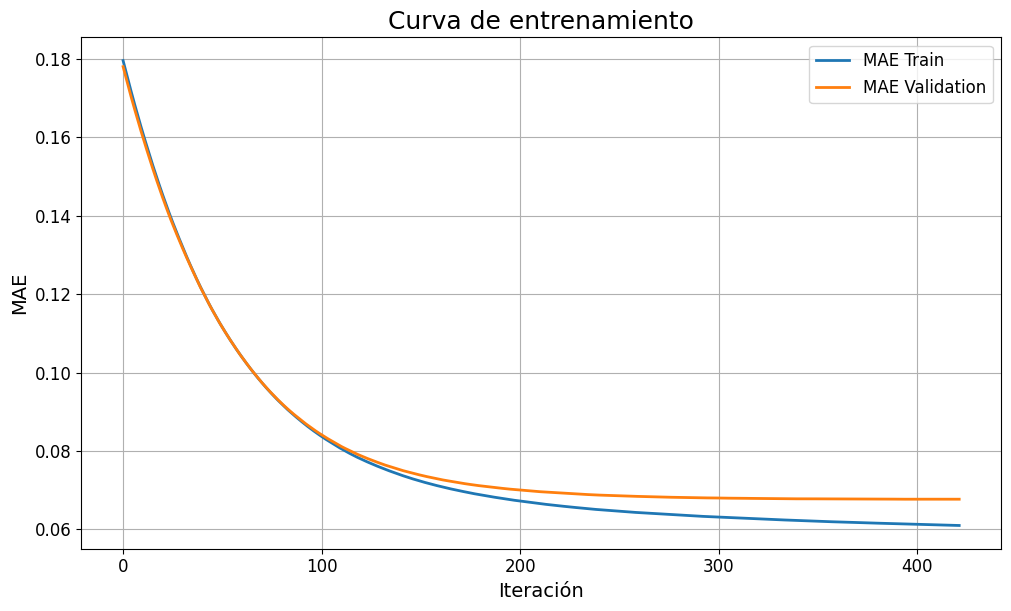

In [36]:
# CURVA DE ENTRENAMIENTO
evals_result = modelo_xgb.evals_result()

train_error = evals_result['validation_0']['mae']
val_error   = evals_result['validation_1']['mae']

plt.figure(figsize=(10, 6))

plt.plot(train_error, label='MAE Train', linewidth=2)
plt.plot(val_error, label='MAE Validation', linewidth=2)

plt.xlabel('Iteración', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.title('Curva de entrenamiento', fontsize=18)

plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

GRÁFICO REAL VS PREDICHO

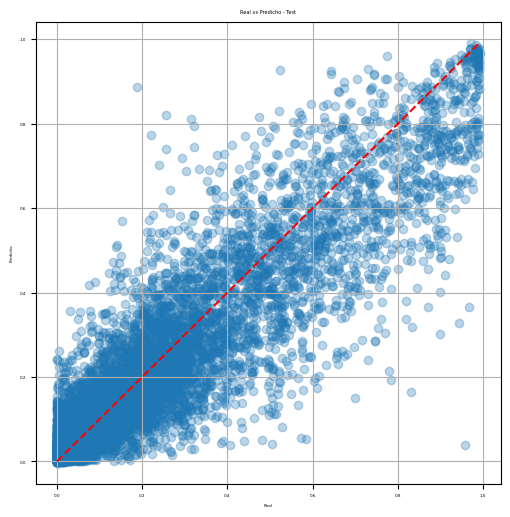

In [37]:
import matplotlib.pyplot as plt

def plot_real_vs_pred(y_true, y_pred, title=""):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Real")
    plt.ylabel("Predicho")
    plt.title(f"Real vs Predicho - {title}")
    plt.grid(True)
    plt.show()

plot_real_vs_pred(y_test, y_pred_test, "Test")


In [38]:
pd.set_option('display.max_rows', None)
importancias = modelo_xgb.feature_importances_

df_importancia = pd.DataFrame({
    'feature': X_trainval.columns,
    'importancia': importancias
}).sort_values(by='importancia', ascending=False)

df_importancia

feature  importancia
6    u100_punto_12_lag1     0.078933
20   v100_punto_11_lag0     0.069213
30  v100_punto_14_lag-1     0.059218
5    u100_punto_12_lag0     0.054998
0    u100_punto_10_lag1     0.053090
37   v100_punto_9_lag-1     0.049329
12   u100_punto_16_lag0     0.048599
35   v100_punto_16_lag0     0.043483
31  v100_punto_15_lag-1     0.040806
16    u100_punto_9_lag0     0.038647
24   v100_punto_12_lag1     0.036911
38    v100_punto_9_lag1     0.032687
27   v100_punto_13_lag1     0.028152
26  v100_punto_13_lag-1     0.027711
13   u100_punto_16_lag1     0.026122
15   u100_punto_9_lag-1     0.018306
10  u100_punto_15_lag-1     0.018200
2   u100_punto_11_lag-1     0.016251
34  v100_punto_16_lag-1     0.015841
3    u100_punto_11_lag2     0.015570
33  v100_punto_16_lag-2     0.015557
11  u100_punto_16_lag-1     0.014591
8    u100_punto_13_lag2     0.014461
21   v100_punto_11_lag2     0.014192
28   v100_punto_13_lag2     0.013764
32   v100_punto_15_lag2     0.013445
14   u100_punto_16_lag2     0.012425
18  v100_punto_10_lag-1     0.011900
29  v100_punto_14_lag-2     0.011564
36   v100_punto_9_lag-2     0.010330
19  v100_punto_11_lag-1     0.009716
7   u100_punto_13_lag-2     0.009451
9   u100_punto_14_lag-2     0.009252
23  v100_punto_12_lag-1     0.008567
22  v100_punto_12_lag-2     0.008062
17  v100_punto_10_lag-2     0.008059
25  v100_punto_13_lag-2     0.007888
4   u100_punto_12_lag-2     0.007461
39               verano     0.007115
1   u100_punto_11_lag-2     0.007036
41             sin_hora     0.006782
40             cos_hora     0.006316

In [39]:
pd.reset_option('display.max_rows')

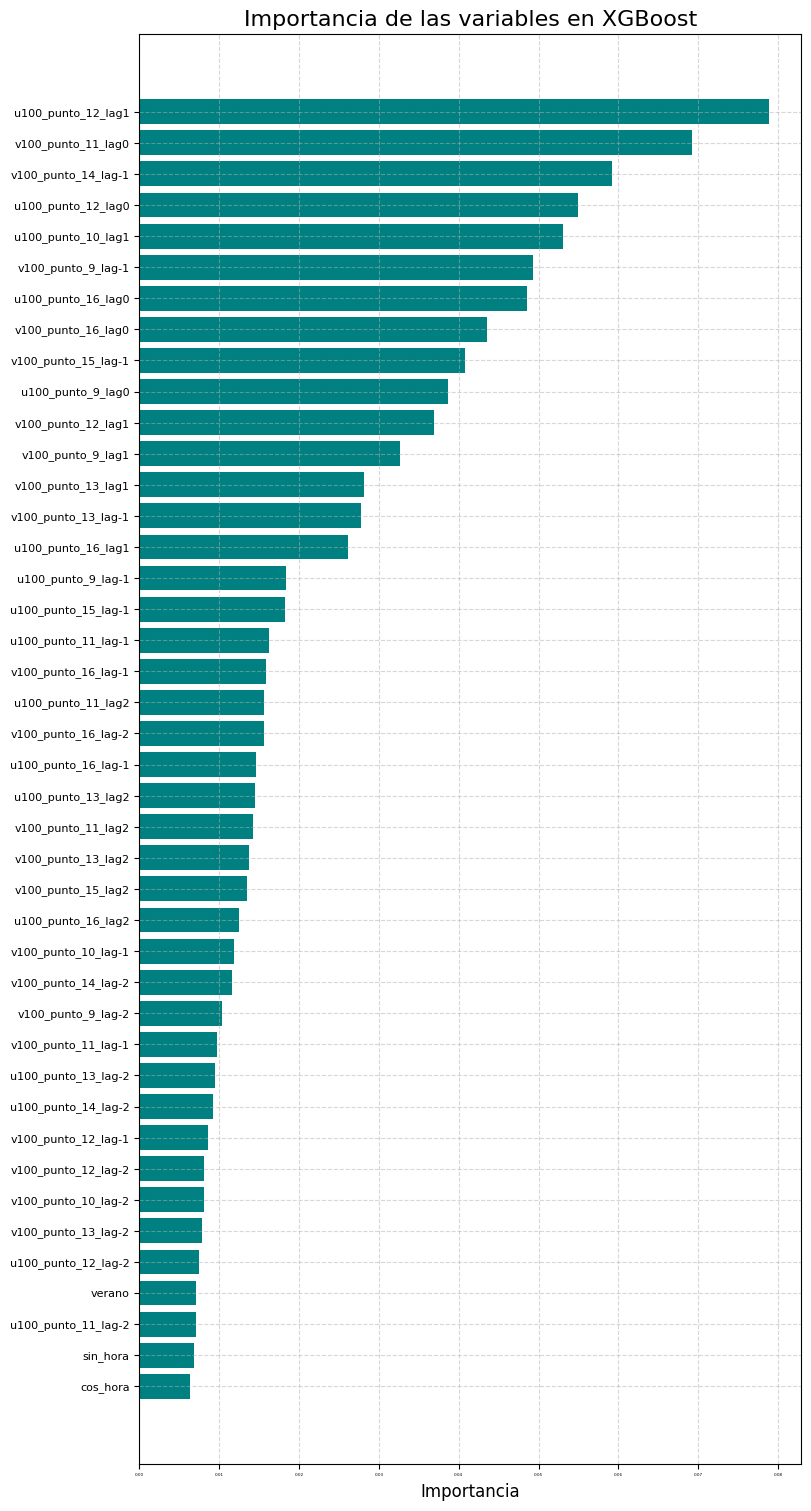

In [40]:
plt.figure(figsize=(8, 15))
plt.barh(df_importancia['feature'], df_importancia['importancia'], color='teal')
plt.xlabel('Importancia', fontsize=12)
plt.title('Importancia de las variables en XGBoost', fontsize=16)
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.5)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


<ipython-input-41-2742892176>:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


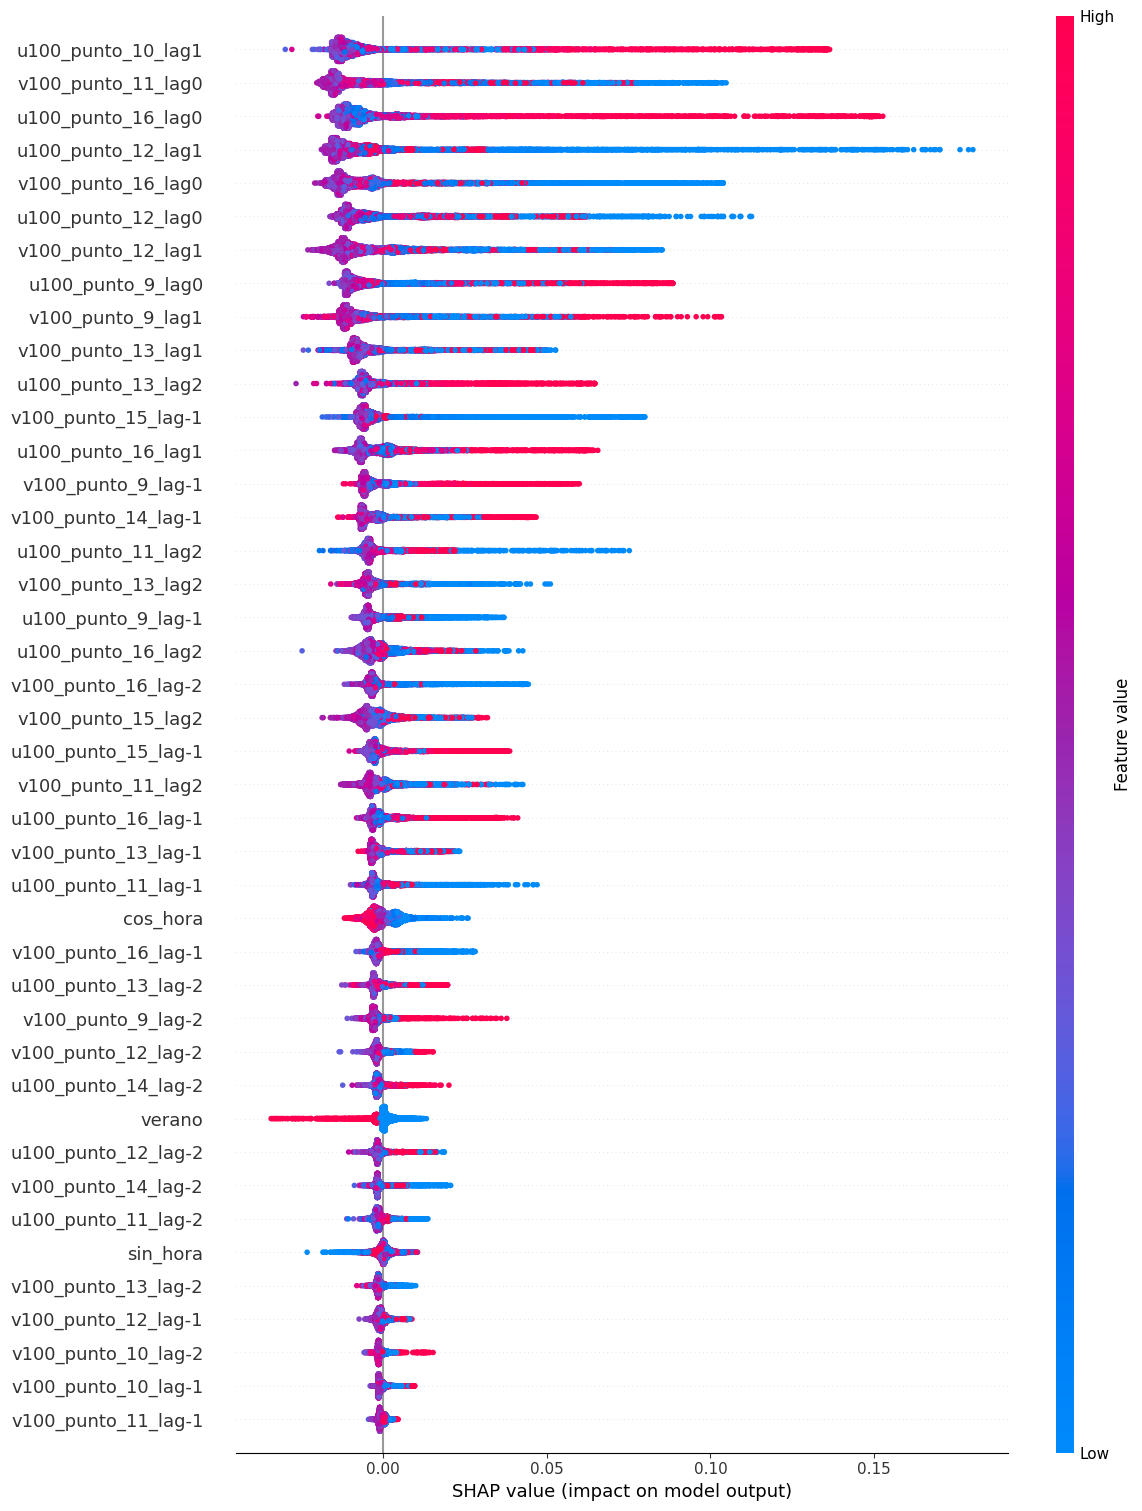

In [41]:
explainer = shap.TreeExplainer(modelo_xgb)

shap_values = explainer.shap_values(X_val)

plt.rcParams.update({'font.size': 3})

shap.summary_plot(
    shap_values,
    X_val,
    max_display=100,
    plot_size=(12, 15)
)

## PRUEBO UTILIZANDO SOLO LAS VAR MÁS IMP

In [44]:
variables_predictoras = [
    'mean_wind_cubed_lag0',
    'mean_wind_cubed_lag1',
    'mean_wind_cubed_lag2',
    'mean_wind_speed_lag-1',
    'mean_wind_cubed_lag-2',
    'mean_wind_cubed_lag-1',
    'mean_wind_speed_lag0',
    'mean_wind_speed_lag-2',
    'u100_punto_13_lag2',
    'verano',
    'u100_punto_16_lag0',
    'u100_punto_16_lag1',
    'v100_punto_9_lag1',
    'u100_punto_16_lag2',
    'cos_hora',
    'sin_hora',
    'u100_punto_13_lag-2',
    'v100_punto_15_lag2',
    'u100_punto_16_lag-1'
]

In [45]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [46]:
# Tamaño del bloque
block_size = 100

# Porcentaje para validación
val_fraction = 0.15

# Número total de bloques
n_blocks = len(X_trainval) // block_size

# Creamos una lista de bloques
blocks = np.arange(n_blocks)

# Fijamos la semilla para que siempre salga igual
np.random.seed(42)

# Mezclamos los bloques aleatoriamente
np.random.shuffle(blocks)

# Seleccionamos bloques para validación
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

# Función para expandir los índices de los bloques
def expand_blocks(block_indices):
    indices = []
    for b in block_indices:
        start = b * block_size
        indices.extend(range(start, start + block_size))
    return indices

# Expandimos los índices
train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

# Cortamos los datos
X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]

X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

# Para comprobar
print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43500 filas
Val: 7600 filas


In [47]:
 evaluar_estabilidad(
    X_train, y_train, X_val, y_val, X_test, y_test,
    mejores_params, n_iter=5
)


Iteración 1, random_state=8484
----- TRAIN -----
MSE:  0.0098
RMSE: 0.0989
MAE:  0.0642
----- VAL -----
MSE:  0.0105
RMSE: 0.1024
MAE:  0.0675
----- TEST -----
MSE:  0.0105
RMSE: 0.1027
MAE:  0.0683

Iteración 2, random_state=2877
----- TRAIN -----
MSE:  0.0097
RMSE: 0.0987
MAE:  0.0639
----- VAL -----
MSE:  0.0104
RMSE: 0.1022
MAE:  0.0673
----- TEST -----
MSE:  0.0105
RMSE: 0.1027
MAE:  0.0683

Iteración 3, random_state=7188
----- TRAIN -----
MSE:  0.0097
RMSE: 0.0985
MAE:  0.0637
----- VAL -----
MSE:  0.0105
RMSE: 0.1022
MAE:  0.0674
----- TEST -----
MSE:  0.0105
RMSE: 0.1026
MAE:  0.0682

Iteración 4, random_state=5112
----- TRAIN -----
MSE:  0.0096
RMSE: 0.0982
MAE:  0.0634
----- VAL -----
MSE:  0.0105
RMSE: 0.1023
MAE:  0.0674
----- TEST -----
MSE:  0.0105
RMSE: 0.1024
MAE:  0.0680

Iteración 5, random_state=4395
----- TRAIN -----
MSE:  0.0098
RMSE: 0.0990
MAE:  0.0643
----- VAL -----
MSE:  0.0104
RMSE: 0.1022
MAE:  0.0673
----- TEST -----
MSE:  0.0106
RMSE: 0.1029
MAE:  0.0685


np.float64(0.068271989958719)

Se observa que al utilizar como variables predictoras las más importantes se obtiene también una métrica muy similar.

## Compruebo la generalidad del optuna

Compruebo que el optuna sigue funcionando aunque cambie el conjunto de entrenamiento y de validación.

BLOQUE 150

In [ ]:
block_size = 150  #cambio de 100 a 150

val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)
np.random.seed(42)

np.random.shuffle(blocks)

n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

def expand_blocks(block_indices):
    indices = []
    for b in block_indices:
        start = b * block_size
        indices.extend(range(start, start + block_size))
    return indices

train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]

X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43350 filas
Val: 7650 filas


In [ ]:
evaluar_estabilidad(
    X_train, y_train, X_val, y_val, X_test, y_test,
    mejores_params, n_iter=5
)


Iteración 1, random_state=2056
----- TRAIN -----
MSE:  0.0096
RMSE: 0.0981
MAE:  0.0631
----- VAL -----
MSE:  0.0106
RMSE: 0.1032
MAE:  0.0686
----- TEST -----
MSE:  0.0110
RMSE: 0.1049
MAE:  0.0696

Iteración 2, random_state=9034
----- TRAIN -----
MSE:  0.0096
RMSE: 0.0981
MAE:  0.0630
----- VAL -----
MSE:  0.0107
RMSE: 0.1034
MAE:  0.0687
----- TEST -----
MSE:  0.0110
RMSE: 0.1050
MAE:  0.0697

Iteración 3, random_state=693
----- TRAIN -----
MSE:  0.0096
RMSE: 0.0979
MAE:  0.0629
----- VAL -----
MSE:  0.0106
RMSE: 0.1031
MAE:  0.0685
----- TEST -----
MSE:  0.0110
RMSE: 0.1048
MAE:  0.0695

Iteración 4, random_state=7588
----- TRAIN -----
MSE:  0.0096
RMSE: 0.0982
MAE:  0.0631
----- VAL -----
MSE:  0.0106
RMSE: 0.1032
MAE:  0.0686
----- TEST -----
MSE:  0.0110
RMSE: 0.1049
MAE:  0.0696

Iteración 5, random_state=8710
----- TRAIN -----
MSE:  0.0096
RMSE: 0.0980
MAE:  0.0629
----- VAL -----
MSE:  0.0107
RMSE: 0.1033
MAE:  0.0685
----- TEST -----
MSE:  0.0110
RMSE: 0.1050
MAE:  0.0698



XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5384243426644809, device=None,
             early_stopping_rounds=10, enable_categorical=False,
             eta=0.011004409128474864, eval_metric=None, feature_types=None,
             gamma=6.004890161169066, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, ...)

BLOQUE 200

In [ ]:
block_size = 200  #cambio de 100 a 200

val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)
np.random.seed(42)

np.random.shuffle(blocks)

n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

def expand_blocks(block_indices):
    indices = []
    for b in block_indices:
        start = b * block_size
        indices.extend(range(start, start + block_size))
    return indices

train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]

X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43400 filas
Val: 7600 filas


In [ ]:
evaluar_estabilidad(
    X_train, y_train, X_val, y_val, X_test, y_test,
    mejores_params, n_iter=5
)


Iteración 1, random_state=5380
----- TRAIN -----
MSE:  0.0094
RMSE: 0.0972
MAE:  0.0624
----- VAL -----
MSE:  0.0121
RMSE: 0.1098
MAE:  0.0742
----- TEST -----
MSE:  0.0110
RMSE: 0.1049
MAE:  0.0698

Iteración 2, random_state=5326
----- TRAIN -----
MSE:  0.0094
RMSE: 0.0971
MAE:  0.0624
----- VAL -----
MSE:  0.0121
RMSE: 0.1098
MAE:  0.0742
----- TEST -----
MSE:  0.0110
RMSE: 0.1049
MAE:  0.0697

Iteración 3, random_state=786
----- TRAIN -----
MSE:  0.0095
RMSE: 0.0973
MAE:  0.0626
----- VAL -----
MSE:  0.0120
RMSE: 0.1097
MAE:  0.0742
----- TEST -----
MSE:  0.0110
RMSE: 0.1049
MAE:  0.0698

Iteración 4, random_state=641
----- TRAIN -----
MSE:  0.0094
RMSE: 0.0972
MAE:  0.0625
----- VAL -----
MSE:  0.0121
RMSE: 0.1098
MAE:  0.0742
----- TEST -----
MSE:  0.0110
RMSE: 0.1050
MAE:  0.0698

Iteración 5, random_state=4143
----- TRAIN -----
MSE:  0.0094
RMSE: 0.0972
MAE:  0.0625
----- VAL -----
MSE:  0.0120
RMSE: 0.1096
MAE:  0.0741
----- TEST -----
MSE:  0.0110
RMSE: 0.1048
MAE:  0.0697

M

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5384243426644809, device=None,
             early_stopping_rounds=10, enable_categorical=False,
             eta=0.011004409128474864, eval_metric=None, feature_types=None,
             gamma=6.004890161169066, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, ...)

BLOQUE 50

In [ ]:
block_size = 50  #cambio de 100 a 50

val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)
np.random.seed(42)

np.random.shuffle(blocks)

n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

def expand_blocks(block_indices):
    indices = []
    for b in block_indices:
        start = b * block_size
        indices.extend(range(start, start + block_size))
    return indices

train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]

X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43450 filas
Val: 7650 filas


In [ ]:
evaluar_estabilidad(
    X_train, y_train, X_val, y_val, X_test, y_test,
    mejores_params, n_iter=5
)


Iteración 1, random_state=5100
----- TRAIN -----
MSE:  0.0092
RMSE: 0.0961
MAE:  0.0619
----- VAL -----
MSE:  0.0127
RMSE: 0.1126
MAE:  0.0752
----- TEST -----
MSE:  0.0109
RMSE: 0.1044
MAE:  0.0697

Iteración 2, random_state=4863
----- TRAIN -----
MSE:  0.0093
RMSE: 0.0962
MAE:  0.0619
----- VAL -----
MSE:  0.0127
RMSE: 0.1126
MAE:  0.0752
----- TEST -----
MSE:  0.0109
RMSE: 0.1044
MAE:  0.0697

Iteración 3, random_state=6811
----- TRAIN -----
MSE:  0.0092
RMSE: 0.0962
MAE:  0.0618
----- VAL -----
MSE:  0.0127
RMSE: 0.1127
MAE:  0.0754
----- TEST -----
MSE:  0.0109
RMSE: 0.1045
MAE:  0.0698

Iteración 4, random_state=8467
----- TRAIN -----
MSE:  0.0093
RMSE: 0.0962
MAE:  0.0619
----- VAL -----
MSE:  0.0127
RMSE: 0.1126
MAE:  0.0752
----- TEST -----
MSE:  0.0109
RMSE: 0.1045
MAE:  0.0698

Iteración 5, random_state=9496
----- TRAIN -----
MSE:  0.0092
RMSE: 0.0961
MAE:  0.0619
----- VAL -----
MSE:  0.0127
RMSE: 0.1126
MAE:  0.0753
----- TEST -----
MSE:  0.0109
RMSE: 0.1046
MAE:  0.0699


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5384243426644809, device=None,
             early_stopping_rounds=10, enable_categorical=False,
             eta=0.011004409128474864, eval_metric=None, feature_types=None,
             gamma=6.004890161169066, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, ...)

# XGBOOST si se utiliza para predecir hora por hora

Pruebo a añadir las producciones de energía éolica en horas pasadas.

## Compruebo cuántas horas anteriores ayudan

In [ ]:
df_completo['lag_1'] = df_completo['Tanto por 1'].shift(1)
df_completo['lag_2'] = df_completo['Tanto por 1'].shift(2)
df_completo['lag_3'] = df_completo['Tanto por 1'].shift(3)
df_completo['lag_4'] = df_completo['Tanto por 1'].shift(4)
df_completo['lag_5'] = df_completo['Tanto por 1'].shift(5)
df_completo['lag_6'] = df_completo['Tanto por 1'].shift(6)
df_completo['lag_7'] = df_completo['Tanto por 1'].shift(7)
df_completo['lag_8'] = df_completo['Tanto por 1'].shift(8)
df_completo['lag_9'] = df_completo['Tanto por 1'].shift(9)
df_completo['lag_10'] = df_completo['Tanto por 1'].shift(10)

In [ ]:
# Elimino los valores nulos generados al hacer los retardos
df_completo = df_completo.dropna()

In [ ]:
df_test = df_completo[df_completo['time'].dt.year == 2022]
df_trainval = df_completo[df_completo['time'].dt.year != 2022]

Al hacer los retardos, en las 10 primeras filas de 2023 (que forma parte del entrenamiento) estoy filtrando información de los 10 últimos días de 2022 (que forma parte del conjunto de entrenamiento), por lo que para evitar que la información se filtre elimino las 10 primeras filas de 2023.

In [ ]:
df_2023 = df_trainval[df_trainval["time"].dt.year == 2023]
indices_a_eliminar = df_2023.index[:10]
df_trainval = df_trainval.drop(index=indices_a_eliminar)

In [ ]:
variables_predictoras =  ['u100_punto_10_lag1',
              'u100_punto_11_lag-2',
              'u100_punto_11_lag-1',
              'u100_punto_11_lag2',
              'u100_punto_12_lag-2',
              'u100_punto_12_lag0',
              'u100_punto_12_lag1',
              'u100_punto_13_lag-2',
              'u100_punto_13_lag2',
              'u100_punto_14_lag-2',
              'u100_punto_15_lag-1',
              'u100_punto_16_lag-1',
              'u100_punto_16_lag0',
              'u100_punto_16_lag1',
              'u100_punto_16_lag2',
              'u100_punto_9_lag-1',
              'u100_punto_9_lag0',
              'v100_punto_10_lag-2',
              'v100_punto_10_lag-1',
              'v100_punto_11_lag-1',
              'v100_punto_11_lag0',
              'v100_punto_11_lag2',
              'v100_punto_12_lag-2',
              'v100_punto_12_lag-1',
              'v100_punto_12_lag1',
              'v100_punto_13_lag-2',
              'v100_punto_13_lag-1',
              'v100_punto_13_lag1',
              'v100_punto_13_lag2',
              'v100_punto_14_lag-2',
              'v100_punto_14_lag-1',
              'v100_punto_15_lag-1',
              'v100_punto_15_lag2',
              'v100_punto_16_lag-2',
              'v100_punto_16_lag-1',
              'v100_punto_16_lag0',
              'v100_punto_9_lag-2',
              'v100_punto_9_lag-1',
              'v100_punto_9_lag1',
              'mean_wind_speed_lag-2',
              'mean_wind_speed_lag-1',
              'mean_wind_speed_lag0',
              'mean_wind_cubed_lag-2',
              'mean_wind_cubed_lag-1',
              'mean_wind_cubed_lag0',
              'mean_wind_cubed_lag1',
              'mean_wind_cubed_lag2',
              'verano',
              'cos_hora',
              'sin_hora',
              'lag_1',
              'lag_2',
              'lag_3',
              'lag_4',
              'lag_5',
              'lag_6',
              'lag_7',
              'lag_8',
              'lag_9',
              'lag_10'
]
objetivo = ['Tanto por 1']

In [ ]:
len(variables_predictoras)

60

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]
train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

Train: 43400 filas
Val: 7600 filas


In [ ]:
resultados = []

for max_lag in range(1, 11):  # desde lag_1 hasta lag_10
    print(f"\n================= Probando hasta lag_{max_lag} =================")

    lags_incluidos = [f'lag_{i}' for i in range(1, max_lag + 1)]
    variables_predictoras_con_lags = [col for col in variables_predictoras if not col.startswith('lag_')] + lags_incluidos

    X_train_sub = X_train[variables_predictoras_con_lags]
    X_val_sub   = X_val[variables_predictoras_con_lags]
    X_test_sub  = X_test[variables_predictoras_con_lags]

    evaluar_estabilidad(
        X_train_sub, y_train,
        X_val_sub, y_val,
        X_test_sub, y_test,
        mejores_params, n_iter=5
    )



================= Probando hasta lag_1 =================

Iteración 1, random_state=4928
----- TRAIN -----
MSE:  0.0046
RMSE: 0.0679
MAE:  0.0413
----- VAL -----
MSE:  0.0053
RMSE: 0.0729
MAE:  0.0459
----- TEST -----
MSE:  0.0052
RMSE: 0.0724
MAE:  0.0455

Iteración 2, random_state=7554
----- TRAIN -----
MSE:  0.0047
RMSE: 0.0686
MAE:  0.0420
----- VAL -----
MSE:  0.0053
RMSE: 0.0730
MAE:  0.0461
----- TEST -----
MSE:  0.0053
RMSE: 0.0727
MAE:  0.0456

Iteración 3, random_state=9306
----- TRAIN -----
MSE:  0.0046
RMSE: 0.0681
MAE:  0.0415
----- VAL -----
MSE:  0.0053
RMSE: 0.0730
MAE:  0.0460
----- TEST -----
MSE:  0.0053
RMSE: 0.0725
MAE:  0.0455

Iteración 4, random_state=6359
----- TRAIN -----
MSE:  0.0047
RMSE: 0.0682
MAE:  0.0417
----- VAL -----
MSE:  0.0053
RMSE: 0.0730
MAE:  0.0461
----- TEST -----
MSE:  0.0053
RMSE: 0.0725
MAE:  0.0455

Iteración 5, random_state=4824
----- TRAIN -----
MSE:  0.0047
RMSE: 0.0685
MAE:  0.0420
----- VAL -----
MSE:  0.0053
RMSE: 0.0731
MAE:  0.046

In [ ]:
resultados = [
    (1, 0.04552, 0.00005),  # MAE con 1 lag y su desviación estándar
    (2, 0.04458, 0.00004),
    (3, 0.04454, 0.00004),
    (4, 0.04455, 0.00003),
    (5, 0.04454, 0.00010),
    (6, 0.04456, 0.00007),
    (7, 0.04456, 0.00004),
    (8, 0.04456, 0.00006),
    (9, 0.04469, 0.00006),
    (10, 0.04469, 0.00005)
]

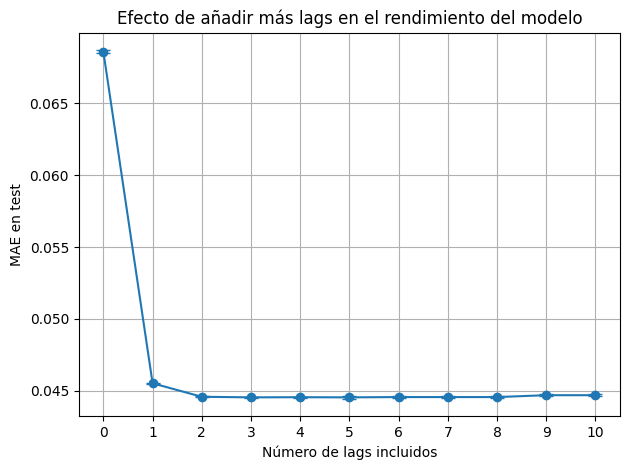

In [ ]:
# Insertamos el punto base sin lags (lag_0) al inicio
resultados_con_0 = [(0, np.float64(0.06859), np.float64(0.0001))] + resultados
lags, maes, stds = zip(*resultados_con_0)

plt.errorbar(lags, maes, yerr=stds, fmt='-o', capsize=5)
plt.xlabel('Número de lags incluidos')
plt.ylabel('MAE en test')
plt.title('Efecto de añadir más lags en el rendimiento del modelo')
plt.xticks(range(0, 11))  # ticks de 0 a 10
plt.grid(True)
plt.tight_layout()
plt.show()

A partir de lag 3 en adelante el MAE ya no mejora significativamente, lo que indica que añadir más retrasos no aporta mejoras claras. Por tanto, mantengo solo la producción de la hora anterior y 2 horas antes.


## Añado producción de las 2 horas anteriores

In [ ]:
df_completo = df_completo.dropna()

In [ ]:
df_test = df_completo[df_completo['time'].dt.year == 2022]
df_trainval = df_completo[df_completo['time'].dt.year != 2022]

Elimino las 2 primeras filas de 2023 para evitar la filtración de información.

In [ ]:
df_2023 = df_trainval[df_trainval["time"].dt.year == 2023]
indices_a_eliminar = df_2023.index[:2]
df_trainval = df_trainval.drop(index=indices_a_eliminar)

In [ ]:
total_rows = len(df_completo)
print(f"Train: {len(df_trainval)} filas ({len(df_trainval)/total_rows:.2%})")
print(f"Test: {len(df_test)} filas ({len(df_test)/total_rows:.2%})")

Train: 51091 filas (85.37%)
Test: 8753 filas (14.63%)


Utilizo las variables y los hiperparámetros escogidos anteriormente.

In [ ]:
variables_predictoras =  ['u100_punto_10_lag1',
             'u100_punto_11_lag-2',
             'u100_punto_11_lag-1',
             'u100_punto_11_lag2',
             'u100_punto_12_lag-2',
             'u100_punto_12_lag0',
             'u100_punto_12_lag1',
             'u100_punto_13_lag-2',
             'u100_punto_13_lag2',
             'u100_punto_14_lag-2',
             'u100_punto_15_lag-1',
             'u100_punto_16_lag-1',
             'u100_punto_16_lag0',
             'u100_punto_16_lag1',
             'u100_punto_16_lag2',
             'u100_punto_9_lag-1',
             'u100_punto_9_lag0',
             'v100_punto_10_lag-2',
             'v100_punto_10_lag-1',
             'v100_punto_11_lag-1',
             'v100_punto_11_lag0',
             'v100_punto_11_lag2',
             'v100_punto_12_lag-2',
             'v100_punto_12_lag-1',
             'v100_punto_12_lag1',
             'v100_punto_13_lag-2',
             'v100_punto_13_lag-1',
             'v100_punto_13_lag1',
             'v100_punto_13_lag2',
             'v100_punto_14_lag-2',
             'v100_punto_14_lag-1',
             'v100_punto_15_lag-1',
             'v100_punto_15_lag2',
             'v100_punto_16_lag-2',
             'v100_punto_16_lag-1',
            'v100_punto_16_lag0',
            'v100_punto_9_lag-2',
            'v100_punto_9_lag-1',
            'v100_punto_9_lag1',
            'mean_wind_speed_lag-2',
            'mean_wind_speed_lag-1',
            'mean_wind_speed_lag0',
            'mean_wind_cubed_lag-2',
            'mean_wind_cubed_lag-1',
            'mean_wind_cubed_lag0',
            'mean_wind_cubed_lag1',
            'mean_wind_cubed_lag2',
            'verano',
            'cos_hora', 'sin_hora', 'lag_1', 'lag_2'


]

objetivo = ['Tanto por 1']

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]
train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)
X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]
print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")



Train: 43400 filas
Val: 7600 filas


In [ ]:
mejores_params ={'booster': 'gbtree', 'colsample_bytree': 0.9226958075139056, 'gamma': 3.3042117927232244, 'learning_rate': 0.014737200478100673,
 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 9.303370212547152, 'reg_lambda': 0.8485082821324884,
                 'subsample': 0.5551226865712834, 'tree_method': 'hist','n_estimators': 10000}

In [ ]:
evaluar_estabilidad(
    X_train, y_train, X_val, y_val, X_test, y_test,
    mejores_params, n_iter=5
)


Iteración 1, random_state=6157
----- TRAIN -----
MSE:  0.0044
RMSE: 0.0667
MAE:  0.0404
----- VAL -----
MSE:  0.0051
RMSE: 0.0717
MAE:  0.0451
----- TEST -----
MSE:  0.0051
RMSE: 0.0714
MAE:  0.0446

Iteración 2, random_state=2149
----- TRAIN -----
MSE:  0.0045
RMSE: 0.0669
MAE:  0.0406
----- VAL -----
MSE:  0.0051
RMSE: 0.0716
MAE:  0.0451
----- TEST -----
MSE:  0.0051
RMSE: 0.0714
MAE:  0.0445

Iteración 3, random_state=6972
----- TRAIN -----
MSE:  0.0045
RMSE: 0.0669
MAE:  0.0406
----- VAL -----
MSE:  0.0052
RMSE: 0.0718
MAE:  0.0451
----- TEST -----
MSE:  0.0051
RMSE: 0.0714
MAE:  0.0445

Iteración 4, random_state=1019
----- TRAIN -----
MSE:  0.0045
RMSE: 0.0671
MAE:  0.0408
----- VAL -----
MSE:  0.0051
RMSE: 0.0717
MAE:  0.0452
----- TEST -----
MSE:  0.0051
RMSE: 0.0715
MAE:  0.0446

Iteración 5, random_state=9651
----- TRAIN -----
MSE:  0.0045
RMSE: 0.0671
MAE:  0.0408
----- VAL -----
MSE:  0.0051
RMSE: 0.0717
MAE:  0.0451
----- TEST -----
MSE:  0.0051
RMSE: 0.0714
MAE:  0.0446


np.float64(0.04457068737724366)